In [1]:
import pdb
import time
import tqdm
import warnings
import traceback
import numpy as np
import pandas as pd
from collections import Counter

from sklearn.metrics import confusion_matrix
from sklearn.metrics import mean_squared_error


warnings.filterwarnings('ignore')
warnings.simplefilter("ignore")


! pip install --upgrade Cython
! pip install --upgrade git+https://github.com/statsmodels/statsmodels

#statsmodels 0.9 is not compatible with SciPy 1.3.0. The current master branch 
#is compatible and the next release will be compatible. The options are to 
#downgrade SciPy, install in a virtual- or conda-env with SciPy 1.2, or to 
#install from master using the code provided above.

# StatsModel - v0.9.0
import statsmodels.tsa.api as smt 
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_pacf,plot_acf
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.arima_model import ARMA

import seaborn as sns
import matplotlib.pyplot as plt

from IPython.display import display
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

Requirement already up-to-date: Cython in /usr/local/lib/python3.6/dist-packages (0.29.10)
  Cloning https://github.com/statsmodels/statsmodels to /tmp/pip-req-build-do0fqqxu
  Running command git clone -q https://github.com/statsmodels/statsmodels /tmp/pip-req-build-do0fqqxu
  Stored in directory: /tmp/pip-ephem-wheel-cache-t3mgakys/wheels/7d/ad/45/ac1a03bd759c2fa74c486e2b1950d94b55f511b4c2b0418bd5
Successfully built statsmodels
  Found existing installation: statsmodels 0.10.0.dev0+1675.g35b6aaba4
    Uninstalling statsmodels-0.10.0.dev0+1675.g35b6aaba4:
      Successfully uninstalled statsmodels-0.10.0.dev0+1675.g35b6aaba4


# Data

In [2]:
def getData(filename, verbose=0):
    df             = pd.read_csv(filename)
    df.columns     = df.columns.str.strip()
    df['DATETIME'] = pd.to_datetime(df['DATETIME'], format='%d/%m/%y %H')
    df.set_index('DATETIME', inplace=True)
    
    
    if verbose:
        print (' -------------------------------------------------------------------------------------- ')
        print (' - Total Len : ', len(df))
        print (' - Label     : ', df['ATT_FLAG'].value_counts())
        print (' - Columns   : ', df.columns, ' || Count : ', len(df.columns))
        print (' - Dates     : ', df.index[0], ' -- ', df.index[-1])
        # print (df.head())
    return df
    
if __name__ == "__main__":
    df_train = getData('data/BATADAL_dataset03.csv', verbose=1)
    df_val   = getData('data/BATADAL_dataset04.csv', verbose=1)

 -------------------------------------------------------------------------------------- 
 - Total Len :  8761
 - Label     :  0    8761
Name: ATT_FLAG, dtype: int64
 - Columns   :  Index(['L_T1', 'L_T2', 'L_T3', 'L_T4', 'L_T5', 'L_T6', 'L_T7', 'F_PU1',
       'S_PU1', 'F_PU2', 'S_PU2', 'F_PU3', 'S_PU3', 'F_PU4', 'S_PU4', 'F_PU5',
       'S_PU5', 'F_PU6', 'S_PU6', 'F_PU7', 'S_PU7', 'F_PU8', 'S_PU8', 'F_PU9',
       'S_PU9', 'F_PU10', 'S_PU10', 'F_PU11', 'S_PU11', 'F_V2', 'S_V2',
       'P_J280', 'P_J269', 'P_J300', 'P_J256', 'P_J289', 'P_J415', 'P_J302',
       'P_J306', 'P_J307', 'P_J317', 'P_J14', 'P_J422', 'ATT_FLAG'],
      dtype='object')  || Count :  44
 - Dates     :  2014-01-06 00:00:00  --  2015-01-06 00:00:00
 -------------------------------------------------------------------------------------- 
 - Total Len :  4177
 - Label     :  -999    3958
 1       219
Name: ATT_FLAG, dtype: int64
 - Columns   :  Index(['L_T1', 'L_T2', 'L_T3', 'L_T4', 'L_T5', 'L_T6', 'L_T7', 'F_PU1',
   

# ARMA - Analysis
 - [Dickey Fuller Test](https://www.statsmodels.org/dev/generated/statsmodels.tsa.stattools.adfuller.html)
     - Augmented Dickey Fuller Test
     - If parameters vary with time,too many parameters to estimate and hence we need the signal to be stationary
 - [ARIMA](https://www.statsmodels.org/devel/generated/statsmodels.tsa.arima_model.ARIMA.fit.html)
 - Goals
     - % Q1 - learn ARMA for atleast 5 individual sensors (huh? which ones)
     - % Q2 - use autocorrelation plots to identify the order of the ARMA models
     - % Q3 - use AIC to determine parameters?
     - % Q4 - Detection threshold should be chosen sensibly
     - % Q5 - Study some anomalies and show what kind you can detect
     - % Q6 - Which sensors can be effectively modelled?

In [3]:
def getStationarityStatus(data, col=''):
    print ('')
    print (' ------------ ',col,' ------------- ')
    test = adfuller(data, autolag='AIC')
    print (' - Test Statistic : ', test[0])
    print (' - pvalue         : ', test[1])
    print (' - usedlag        : ', test[2])
    print (' - nobs           : ', test[3])
    print (' - critical vals  : ', test[4])
    if (test[1] < 0.05):
        return 1
    

for col in ['L_T1', 'L_T2', 'L_T3', 'L_T4', 'L_T5', 'L_T6', 'L_T7', 'F_PU1',
       'S_PU1', 'F_PU2', 'S_PU2', 'F_PU3', 'S_PU3', 'F_PU4', 'S_PU4', 'F_PU5',
       'S_PU5', 'F_PU6', 'S_PU6', 'F_PU7', 'S_PU7', 'F_PU8', 'S_PU8', 'F_PU9',
       'S_PU9', 'F_PU10', 'S_PU10', 'F_PU11', 'S_PU11', 'F_V2', 'S_V2',
       'P_J280', 'P_J269', 'P_J300', 'P_J256', 'P_J289', 'P_J415', 'P_J302',
       'P_J306', 'P_J307', 'P_J317', 'P_J14', 'P_J422']: #['F_PU1', 'F_PU2', 'F_V2', 'P_J289', 'P_J269', 'P_J307', 'P_J14' ]:
    getStationarityStatus(df_train[col], col=col)

# sensors to check for :
# getStationarityStatus(df_train['L_T2'])
# getStationarityStatus(df_train['L_T3'])


 ------------  L_T1  ------------- 
 - Test Statistic :  -20.615633377091587
 - pvalue         :  0.0
 - usedlag        :  37
 - nobs           :  8723
 - critical vals  :  {'1%': -3.431099882538333, '5%': -2.8618713981324873, '10%': -2.56694639826003}

 ------------  L_T2  ------------- 
 - Test Statistic :  -18.61272583053186
 - pvalue         :  2.064477163371469e-30
 - usedlag        :  36
 - nobs           :  8724
 - critical vals  :  {'1%': -3.431099796556747, '5%': -2.861871360139148, '10%': -2.5669463780359156}

 ------------  L_T3  ------------- 
 - Test Statistic :  -14.375781649934819
 - pvalue         :  9.32987473394279e-27
 - usedlag        :  37
 - nobs           :  8723
 - critical vals  :  {'1%': -3.431099882538333, '5%': -2.8618713981324873, '10%': -2.56694639826003}

 ------------  L_T4  ------------- 
 - Test Statistic :  -16.582866405756523
 - pvalue         :  1.827583797050683e-29
 - usedlag        :  27
 - nobs           :  8733
 - critical vals  :  {'1%': -3.4

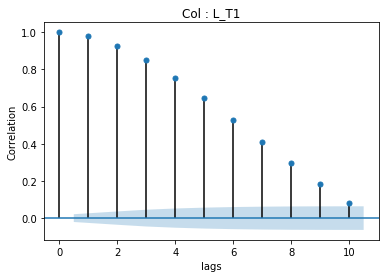

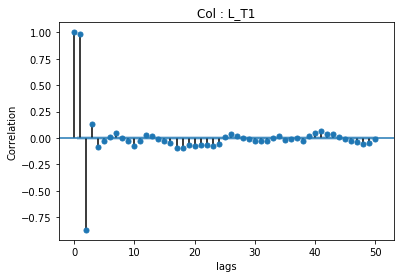

 -------------------------- 


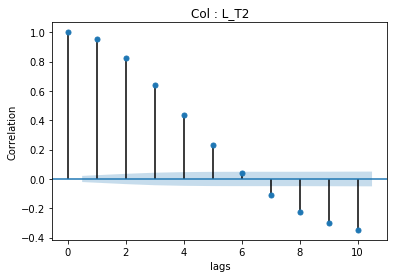

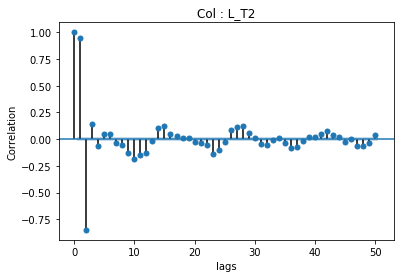

 -------------------------- 


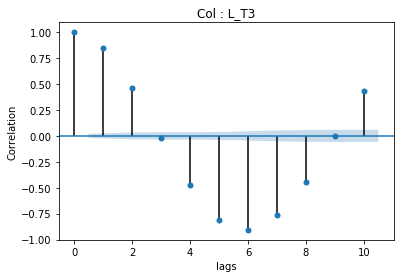

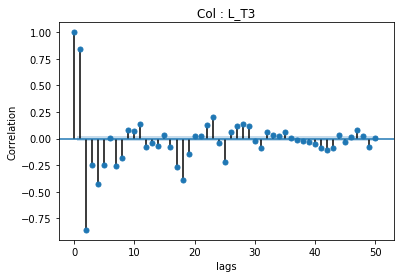

 -------------------------- 


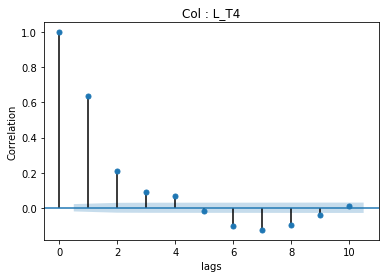

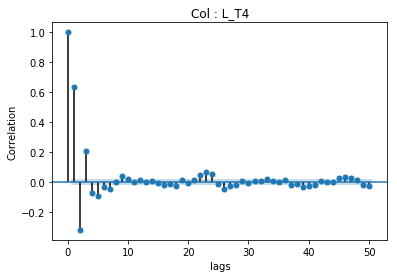

 -------------------------- 


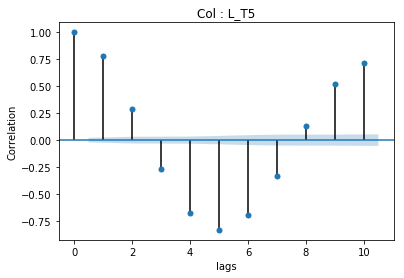

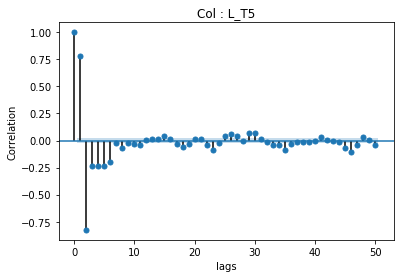

 -------------------------- 


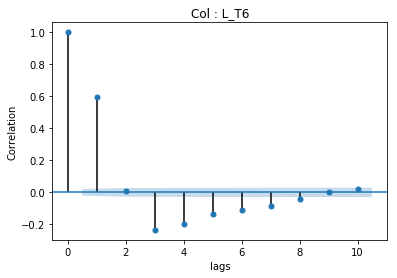

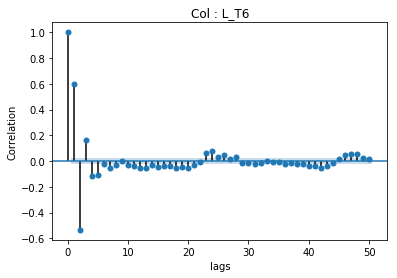

 -------------------------- 


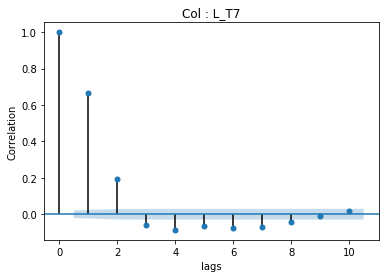

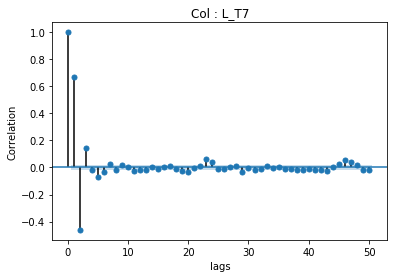

 -------------------------- 


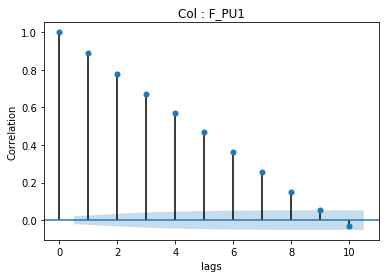

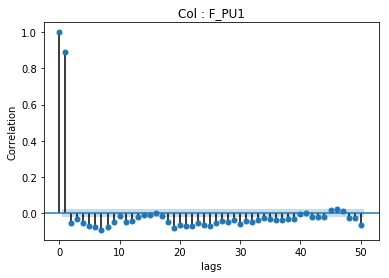

 -------------------------- 


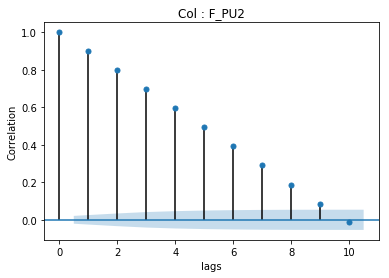

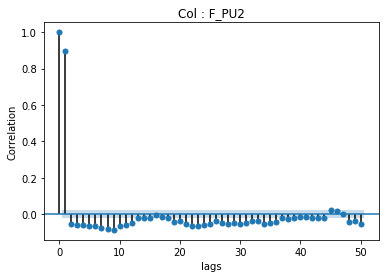

 -------------------------- 


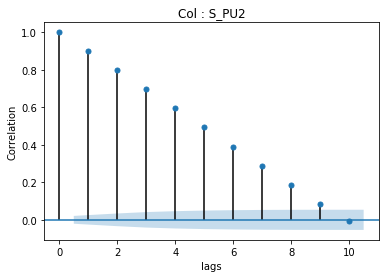

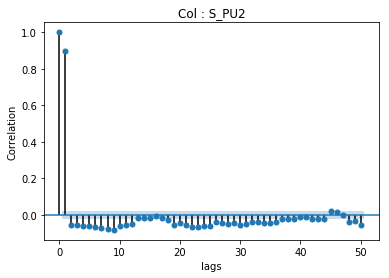

 -------------------------- 


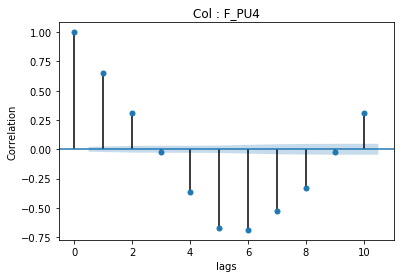

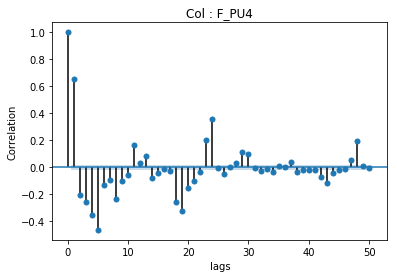

 -------------------------- 


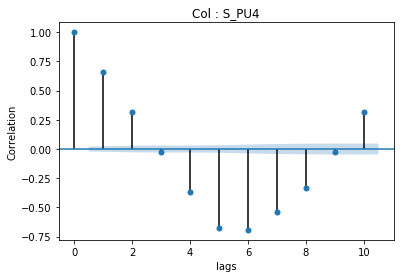

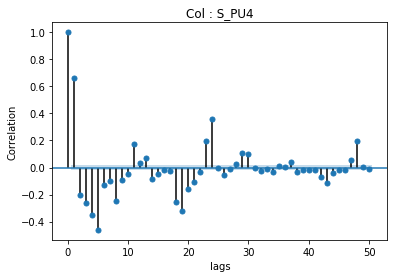

 -------------------------- 


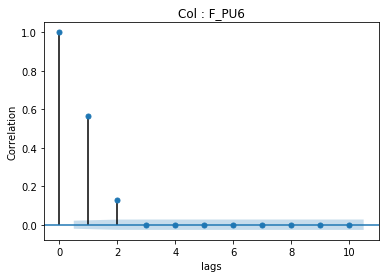

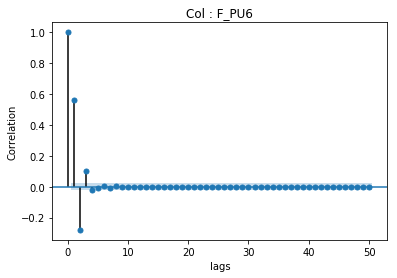

 -------------------------- 


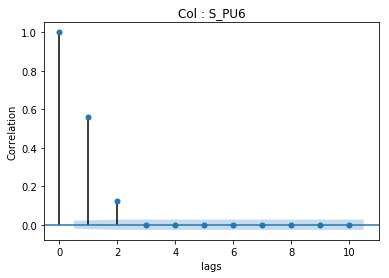

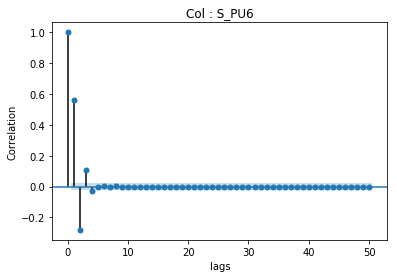

 -------------------------- 


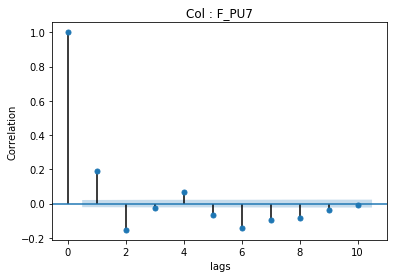

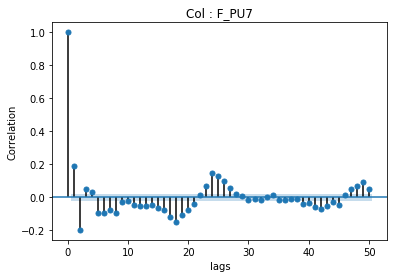

 -------------------------- 


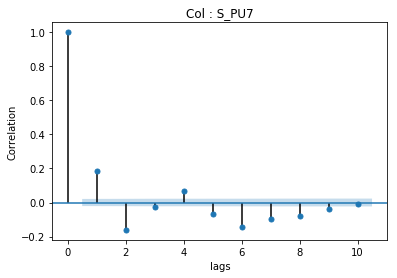

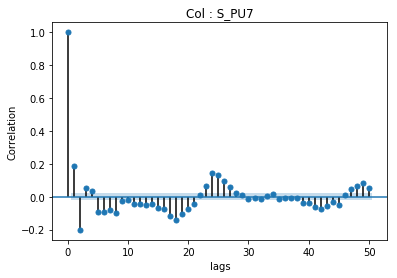

 -------------------------- 


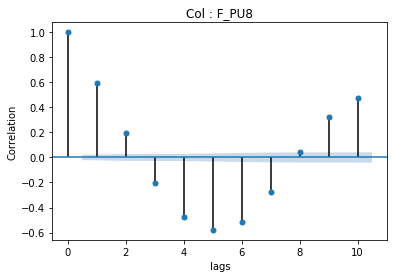

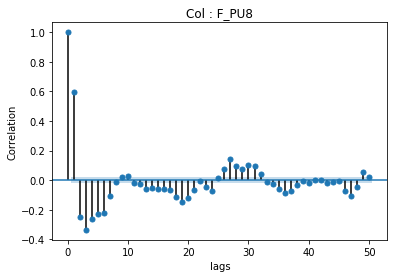

 -------------------------- 


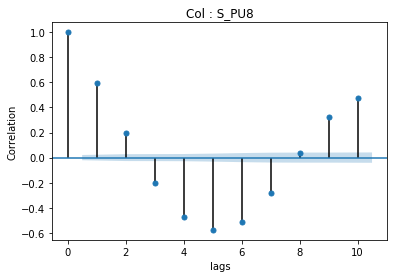

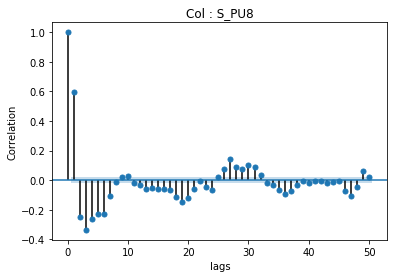

 -------------------------- 


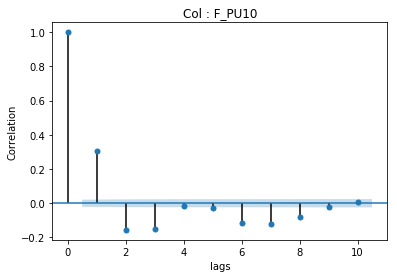

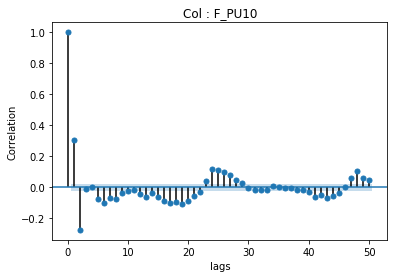

 -------------------------- 


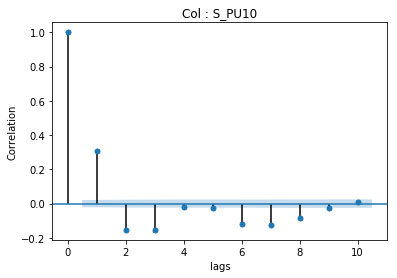

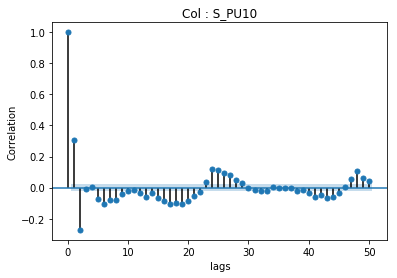

 -------------------------- 


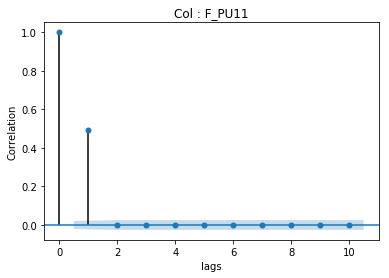

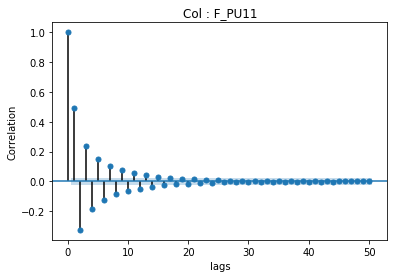

 -------------------------- 


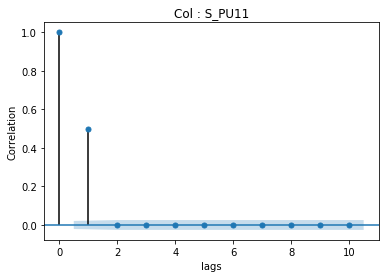

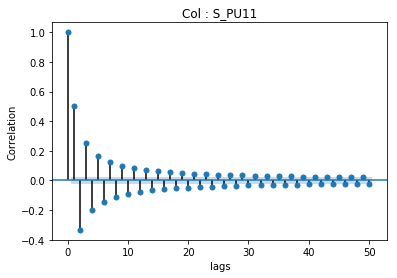

 -------------------------- 


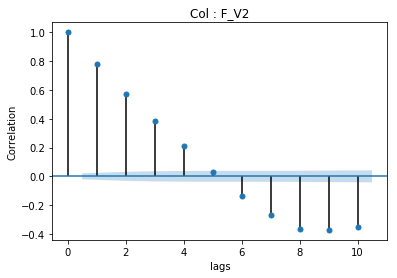

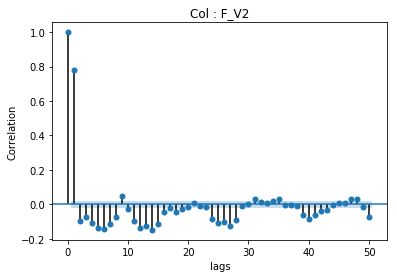

 -------------------------- 


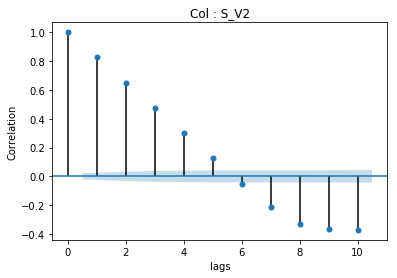

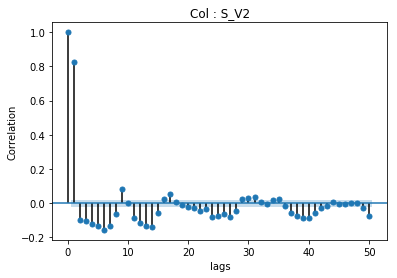

 -------------------------- 


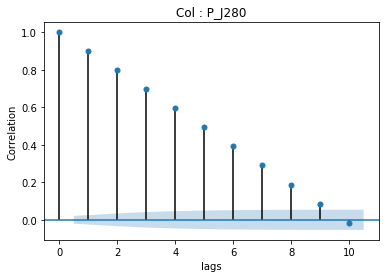

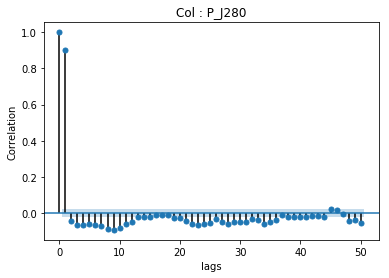

 -------------------------- 


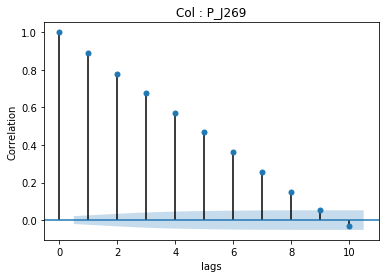

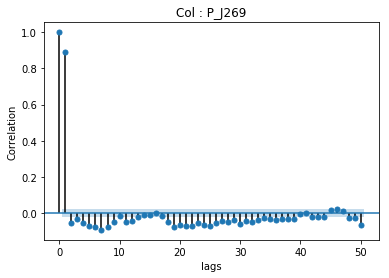

 -------------------------- 


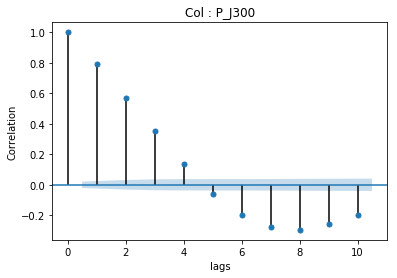

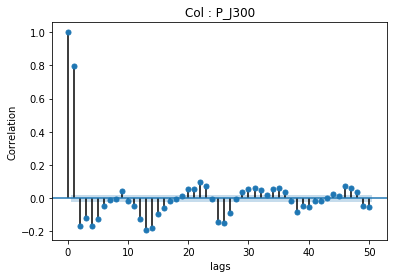

 -------------------------- 


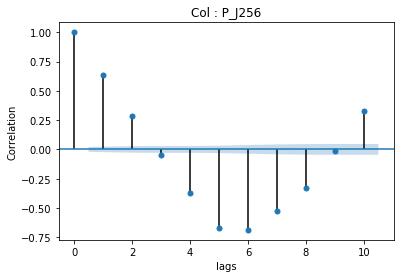

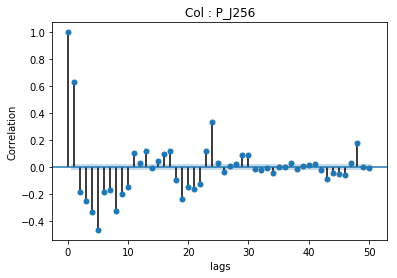

 -------------------------- 


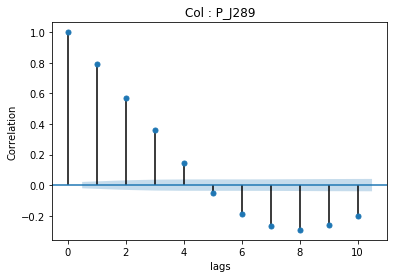

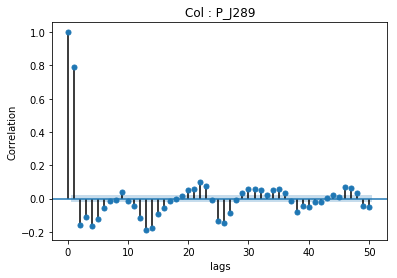

 -------------------------- 


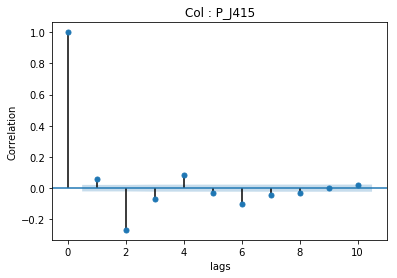

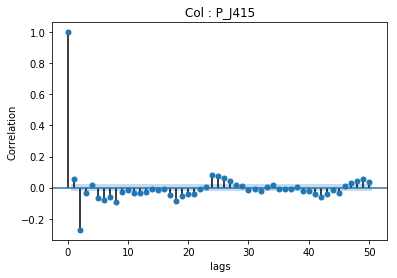

 -------------------------- 


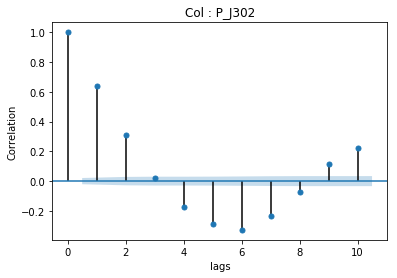

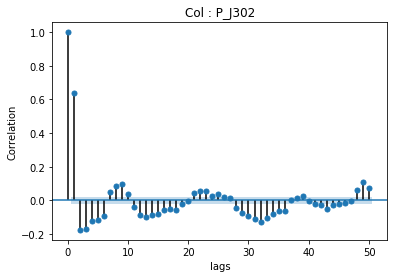

 -------------------------- 


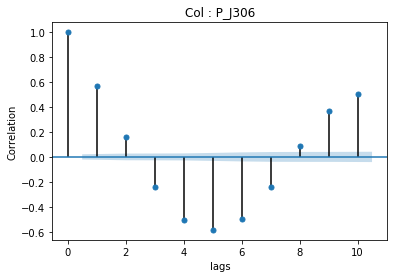

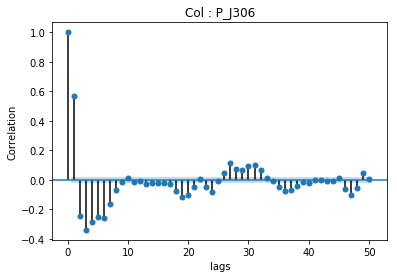

 -------------------------- 


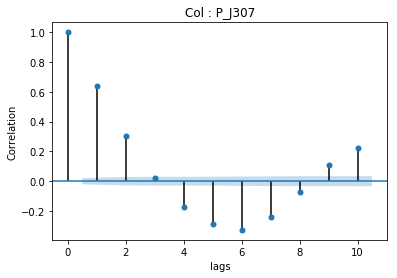

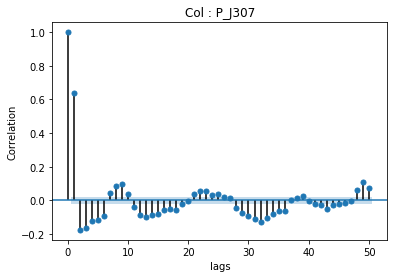

 -------------------------- 


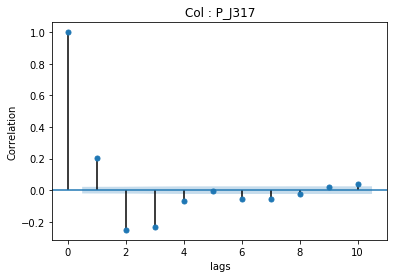

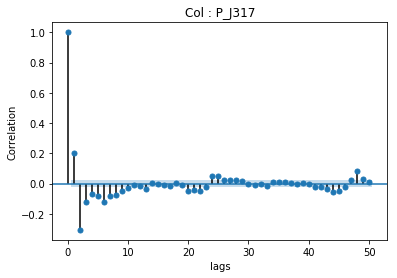

 -------------------------- 


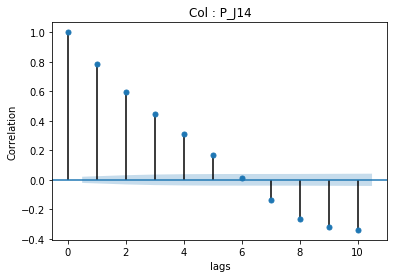

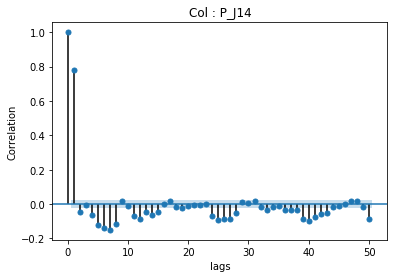

 -------------------------- 


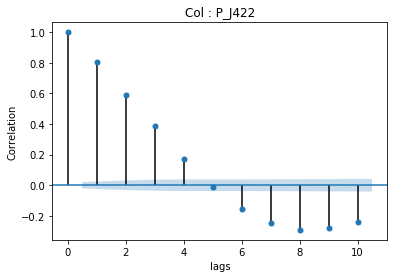

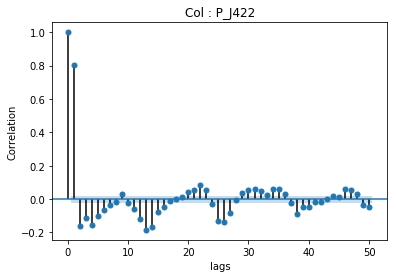

 -------------------------- 


In [0]:
def plotACF(data, col=''):
    plot_acf(data, lags=10)
    plt.xlabel('lags'); plt.ylabel('Correlation'); plt.title('Col : ' + str(col))
    plot_pacf(data, lags=50)
    plt.xlabel('lags'); plt.ylabel('Correlation'); plt.title('Col : ' + str(col))
    plt.show()
    print (' -------------------------- ')
    
    """
     - 5% chance that iftrue autocorrelation is zero, it will fall outside blue band
    """
# removed due to singular matrix ['S_PU1', 'F_PU3', 'S_PU3', 'F_PU5', 'S_PU5', 'F_PU9', 'S_PU9', 'F_PU8' , 'F_V2', 'P_J280',  'P_J289','P_J306']
for col in ['L_T1', 'L_T2', 'L_T3', 'L_T4', 'L_T5', 'L_T6', 'L_T7', 'F_PU1', 'F_PU2', 'S_PU2', 'F_PU4', 'S_PU4', 'F_PU6', 'S_PU6', 'F_PU7', 'S_PU7', 'S_PU8', 'F_PU10', 'S_PU10', 'F_PU11', 'S_PU11', 'S_V2',
       'P_J269', 'P_J300', 'P_J256', 'P_J415', 'P_J302', 'P_J307', 'P_J317', 'P_J14', 'P_J422']:
    plotACF(df_train[col], col=col)
# plotACF(df_train['F_PU1'])
# plotACF(df_val['L_T1'])
# plotACF(df_train['L_T4'])
# plotACF(df_val['L_T4'])



# ARMA - Getting params


 ------------------ col :  L_T1  -------------------- 
 - ARIMA Results :  3 4  || AIC :  -13232.106912376079  (Time :  114.28 s)
  -- Threshold Val:  0.763


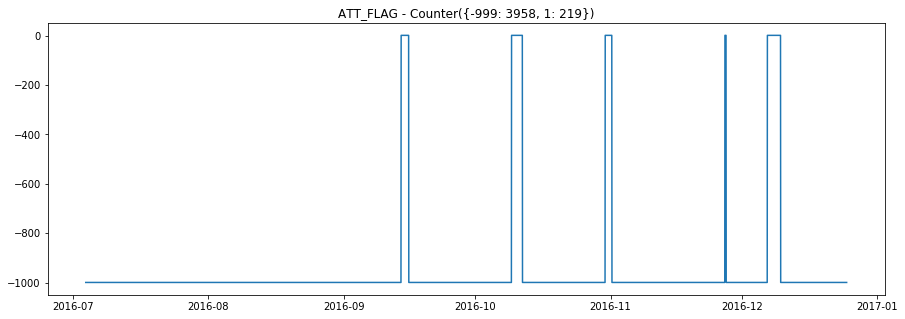

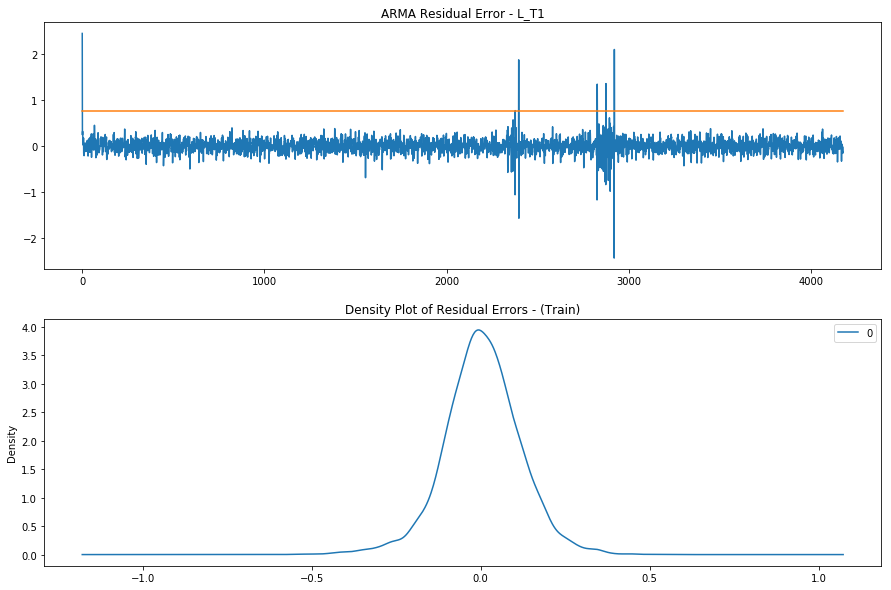

  -- TP :  3  || FP :  3


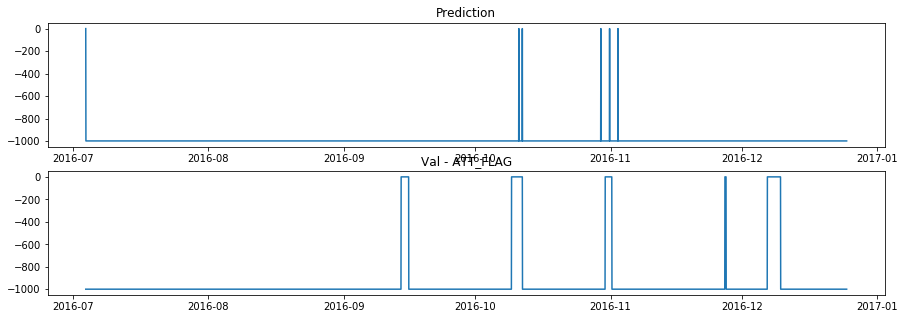


 ------------------ col :  L_T2  -------------------- 
 - ARIMA Results :  4 4  || AIC :  -228.31051172601292  (Time :  200.49 s)
  -- Threshold Val:  1.245


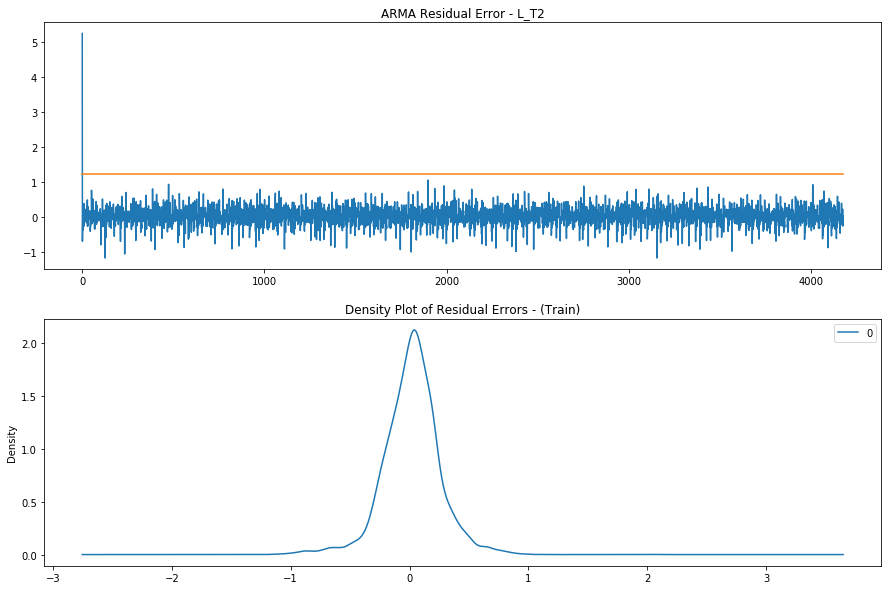

  -- TP :  0  || FP :  0


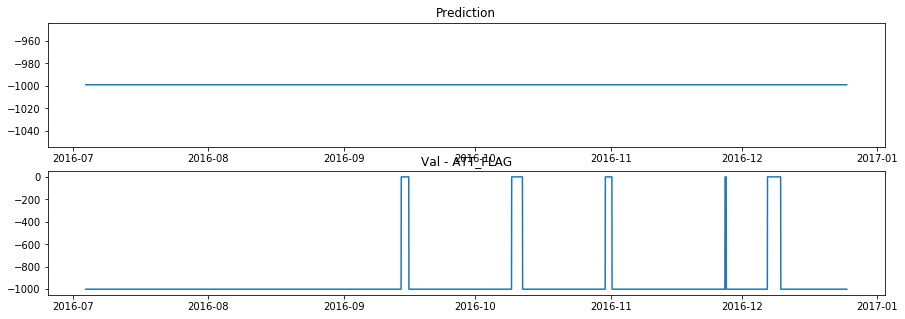


 ------------------ col :  L_T3  -------------------- 
 - ARIMA Results :  3 4  || AIC :  -7158.990509138228  (Time :  78.27 s)
  -- Threshold Val:  0.849


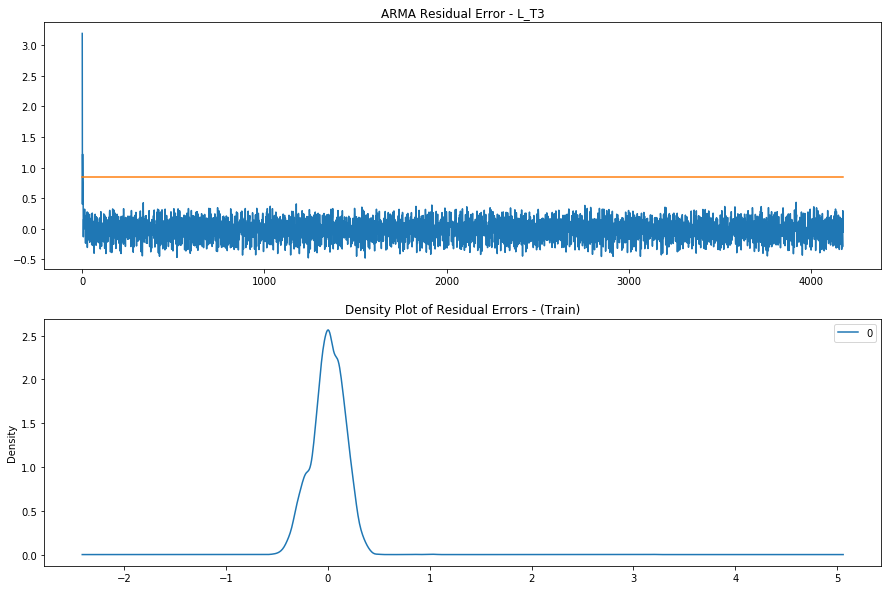

  -- TP :  0  || FP :  2


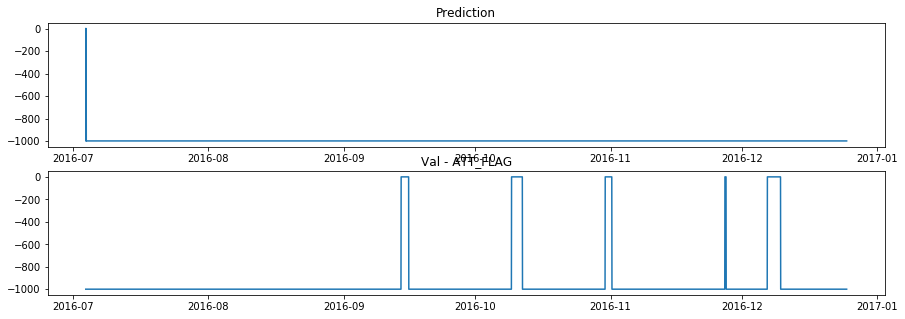


 ------------------ col :  L_T4  -------------------- 
 - ARIMA Results :  4 2  || AIC :  8236.754398880352  (Time :  152.86 s)
  -- Threshold Val:  1.972


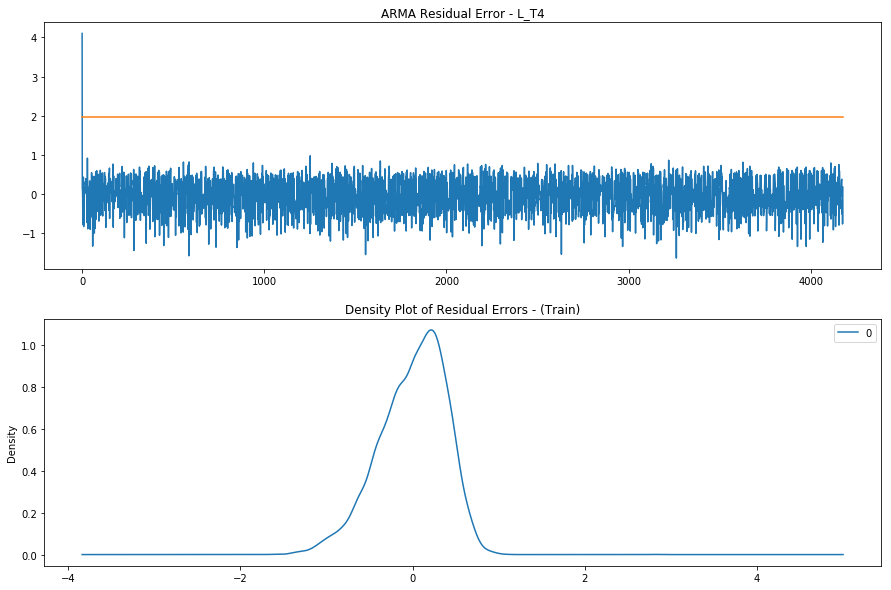

  -- TP :  0  || FP :  0


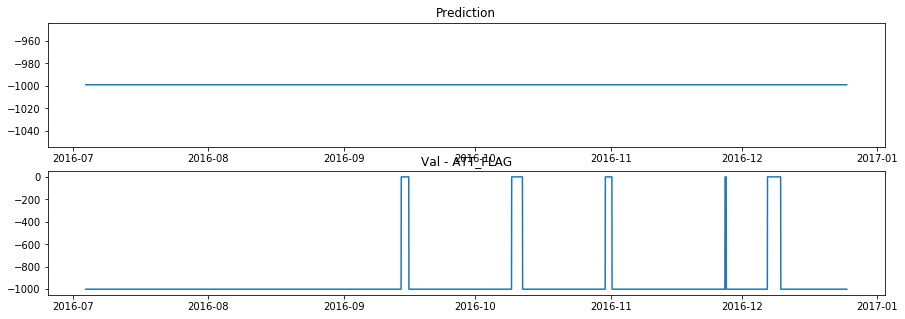


 ------------------ col :  L_T5  -------------------- 
 - ARIMA Results :  4 4  || AIC :  -517.0084731960633  (Time :  55.21 s)
  -- Threshold Val:  1.183


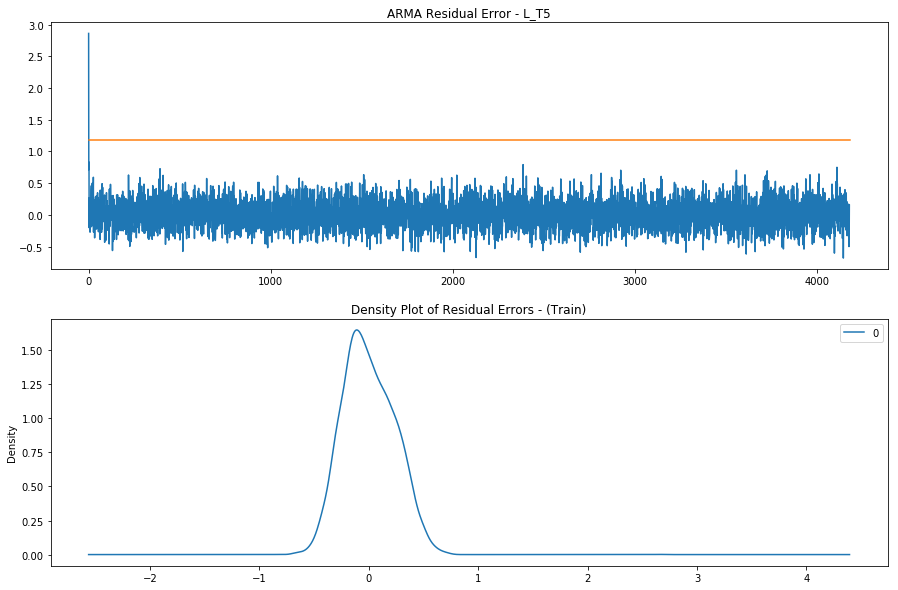

  -- TP :  0  || FP :  0


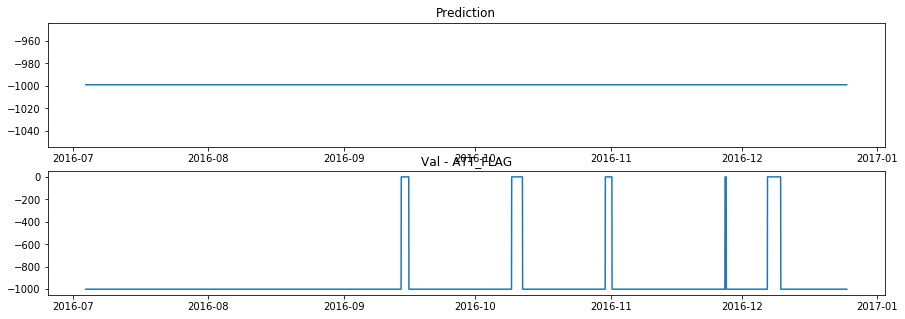


 ------------------ col :  L_T6  -------------------- 
 - ARIMA Results :  3 2  || AIC :  -12467.22429253162  (Time :  41.49 s)
  -- Threshold Val:  0.732


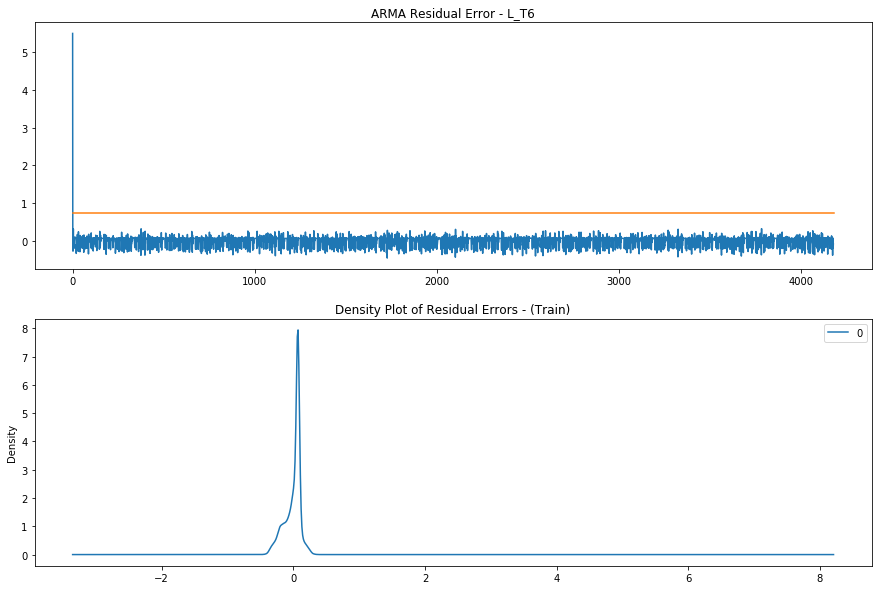

  -- TP :  0  || FP :  1


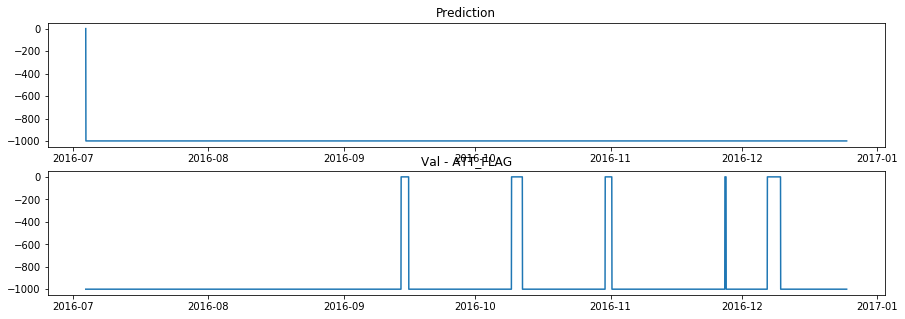


 ------------------ col :  L_T7  -------------------- 
 - ARIMA Results :  3 4  || AIC :  14075.77281783206  (Time :  157.06 s)
  -- Threshold Val:  2.734


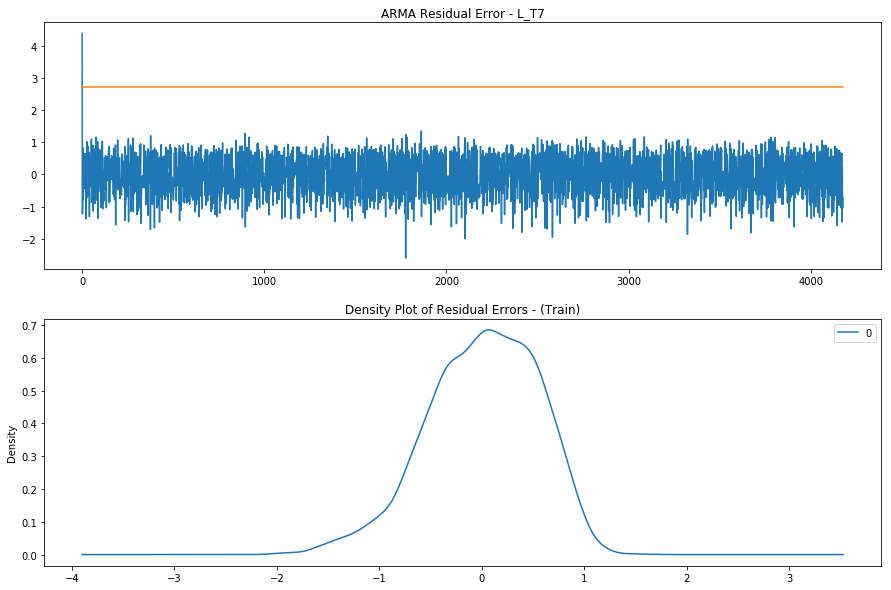

  -- TP :  0  || FP :  0


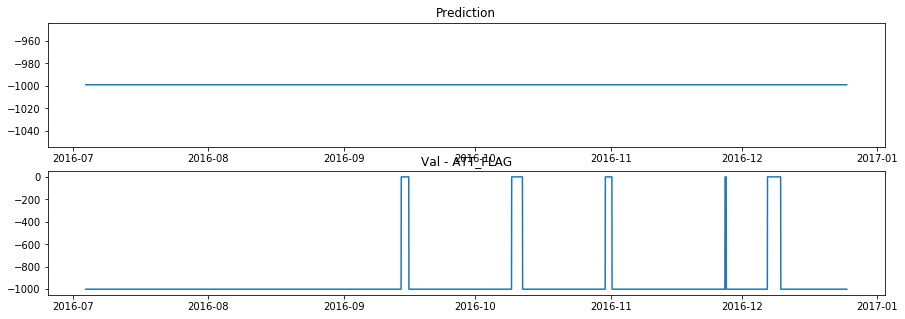


 ------------------ col :  F_PU1  -------------------- 
 - ARIMA Results :  4 2  || AIC :  51591.60502136791  (Time :  148.19 s)
  -- Threshold Val:  24.598


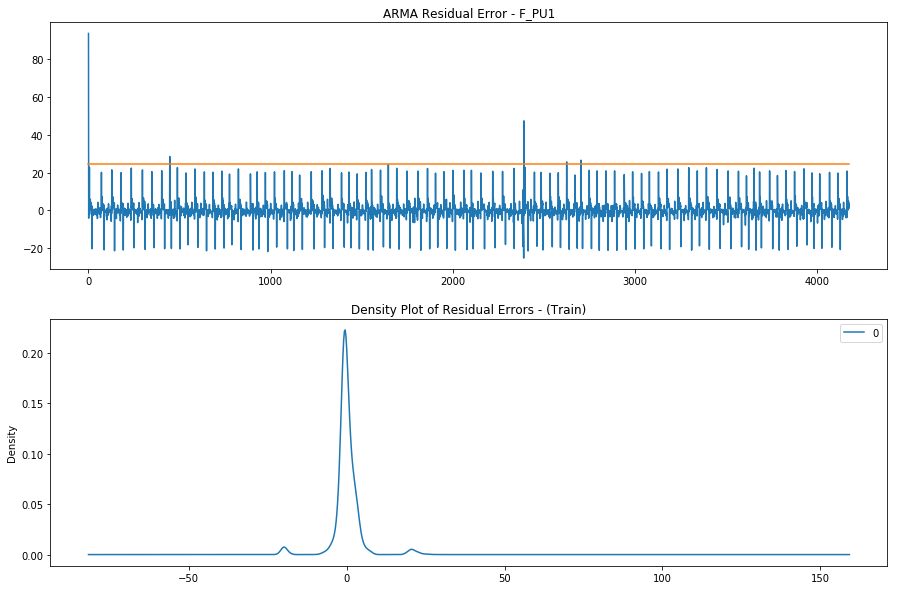

  -- TP :  0  || FP :  0


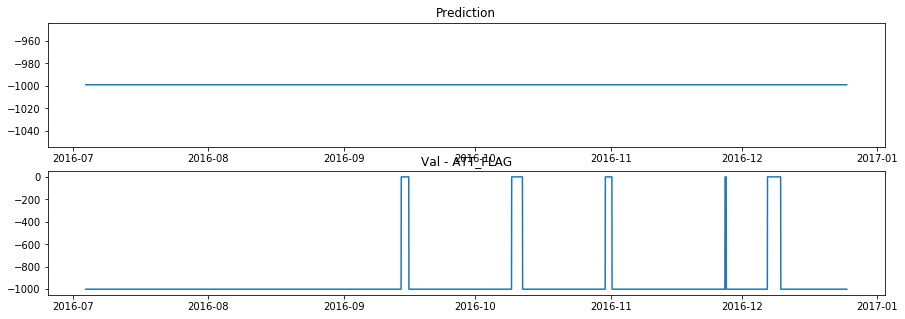


 ------------------ col :  F_PU2  -------------------- 
 - ARIMA Results :  1 3  || AIC :  76308.24216397347  (Time :  19.71 s)
  -- Threshold Val:  94.511


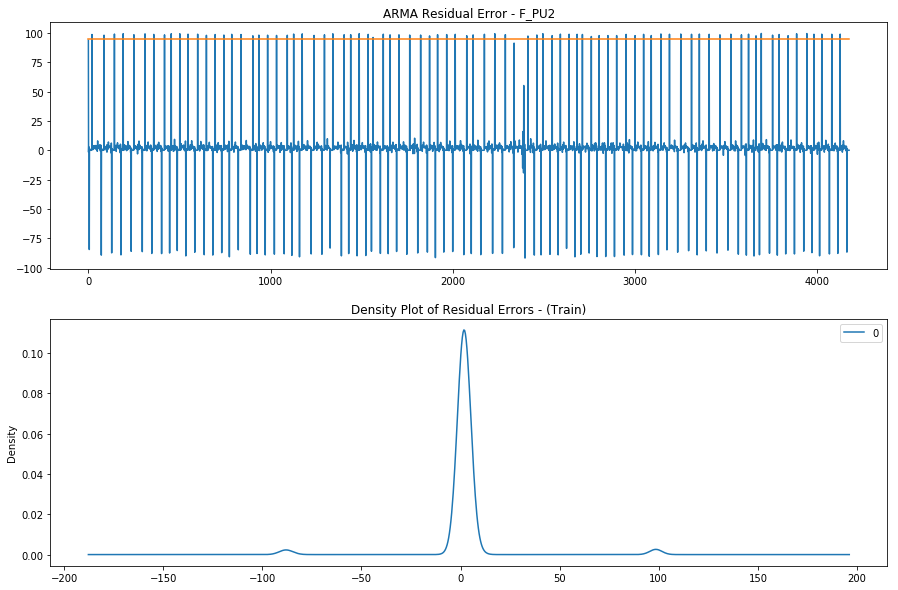

  -- TP :  0  || FP :  0


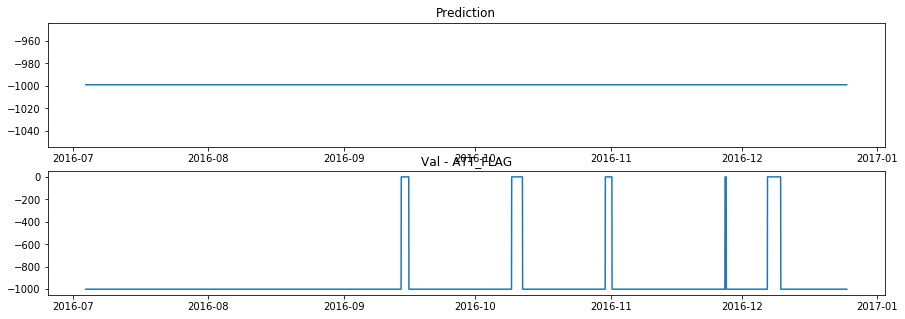


 ------------------ col :  S_PU2  -------------------- 
 - ARIMA Results :  1 1  || AIC :  -3460.890907807763  (Time :  19.87 s)
  -- Threshold Val:  0.996


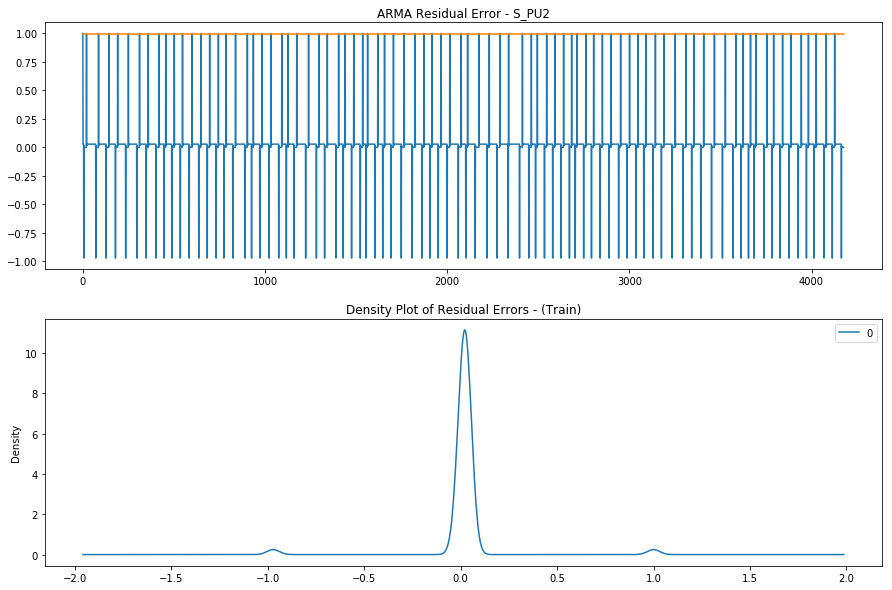

  -- TP :  5  || FP :  80


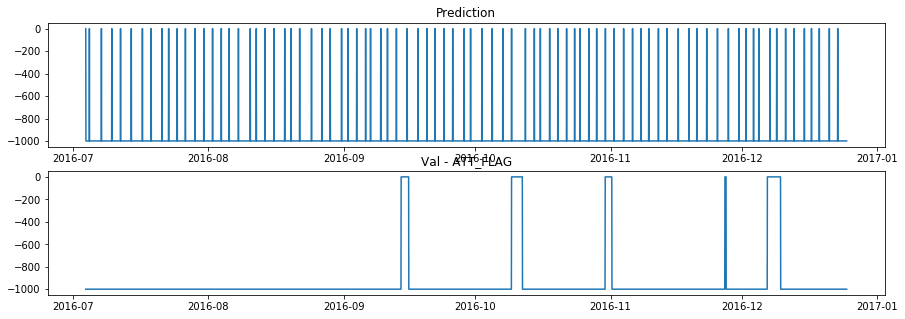


 ------------------ col :  F_PU4  -------------------- 
 - ARIMA Results :  4 4  || AIC :  64906.683288685585  (Time :  109.5 s)
  -- Threshold Val:  49.378


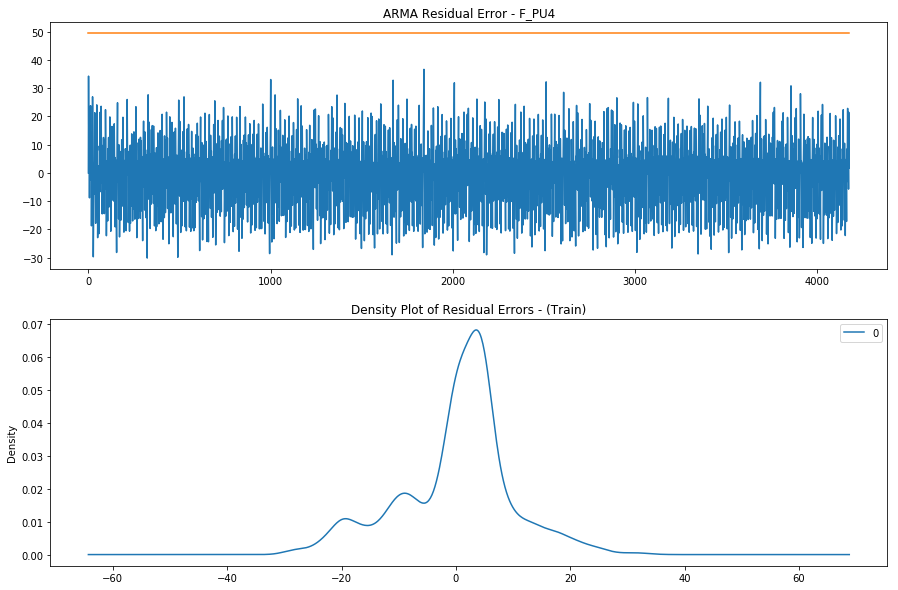

  -- TP :  0  || FP :  0


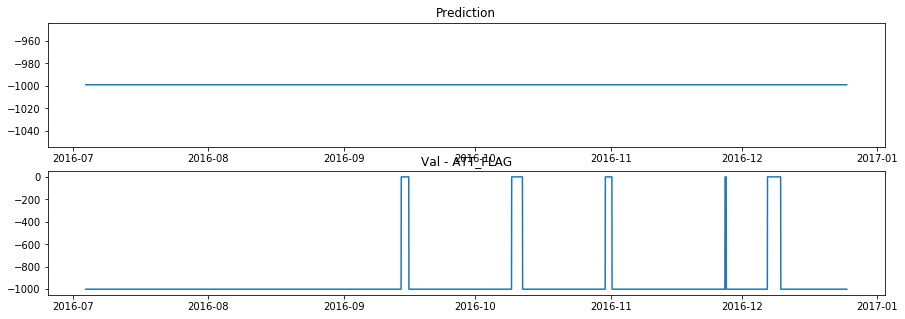


 ------------------ col :  S_PU4  -------------------- 
 - ARIMA Results :  4 4  || AIC :  2693.415761217999  (Time :  129.03 s)
  -- Threshold Val:  1.419


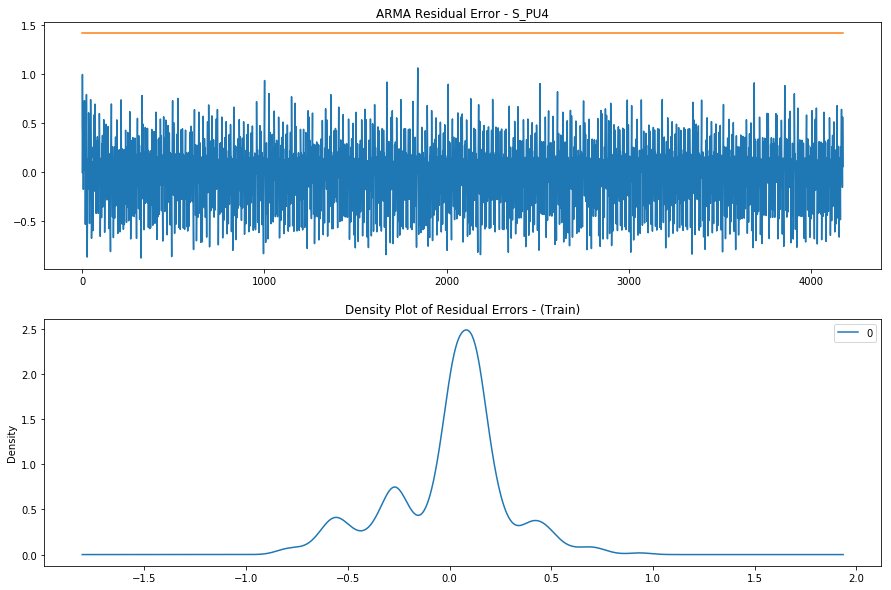

  -- TP :  0  || FP :  0


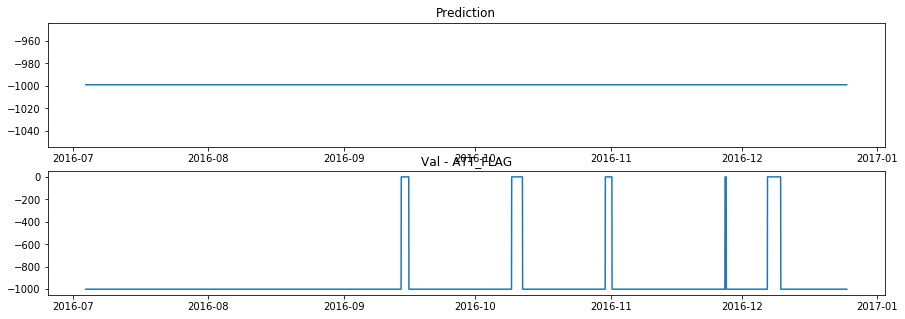


 ------------------ col :  F_PU6  -------------------- 
 - ARIMA Results :  1 2  || AIC :  28590.579698764257  (Time :  36.07 s)
  -- Threshold Val:  17.259


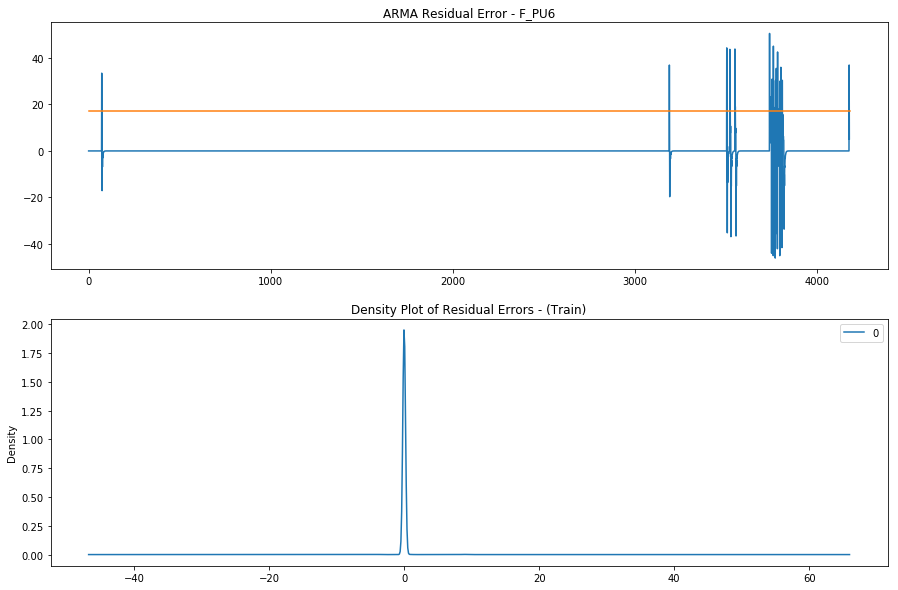

  -- TP :  0  || FP :  0


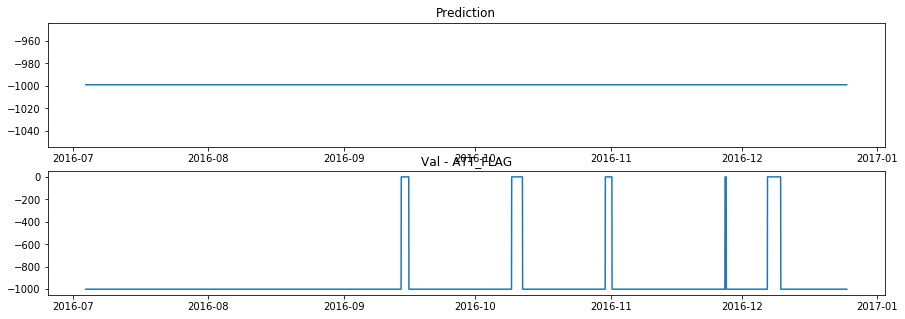


 ------------------ col :  S_PU6  -------------------- 
 - ARIMA Results :  1 2  || AIC :  -34526.35637504088  (Time :  37.13 s)
  -- Threshold Val:  0.38


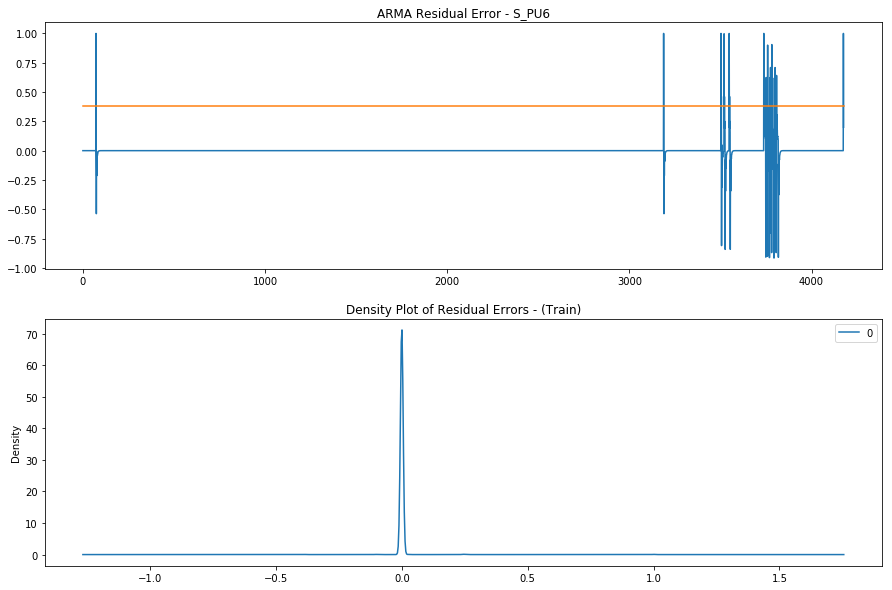

  -- TP :  8  || FP :  11


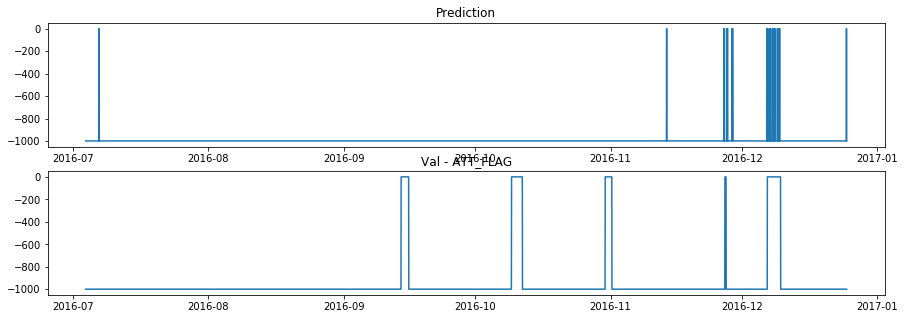


 ------------------ col :  F_PU7  -------------------- 
 - ARIMA Results :  3 3  || AIC :  74626.11609816593  (Time :  88.01 s)
  -- Threshold Val:  87.247


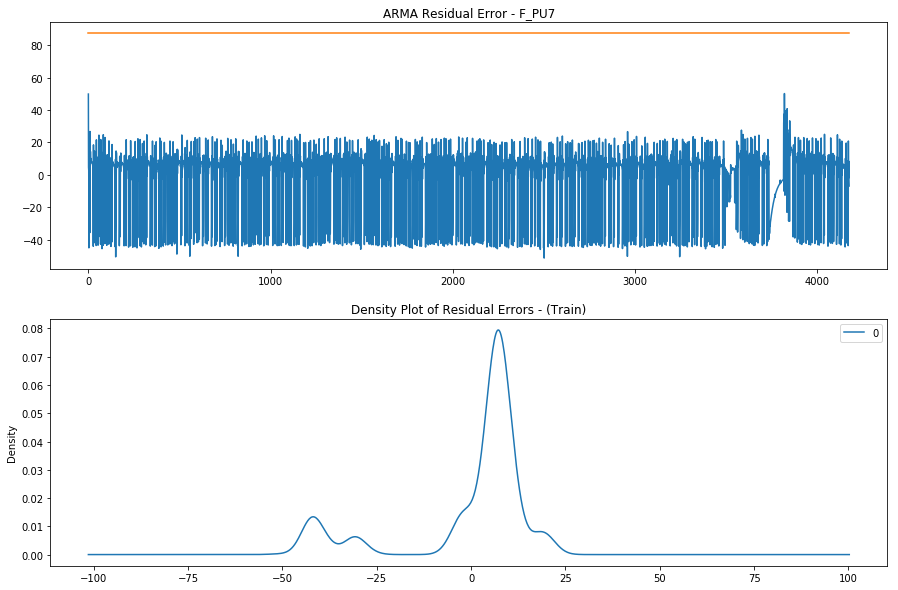

  -- TP :  0  || FP :  0


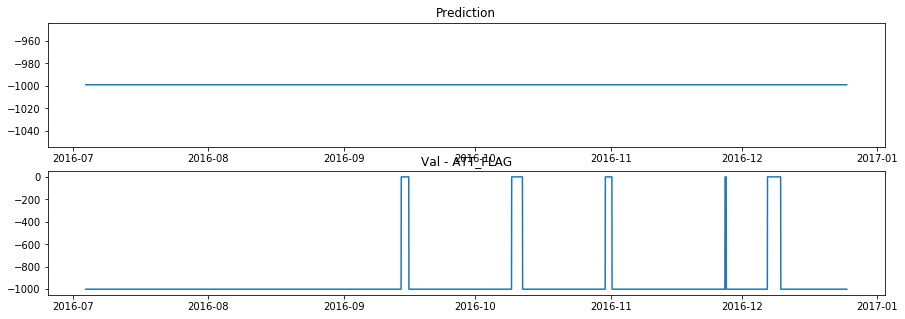


 ------------------ col :  S_PU7  -------------------- 
 - ARIMA Results :  2 3  || AIC :  6129.296528146195  (Time :  184.12 s)
  -- Threshold Val:  1.777


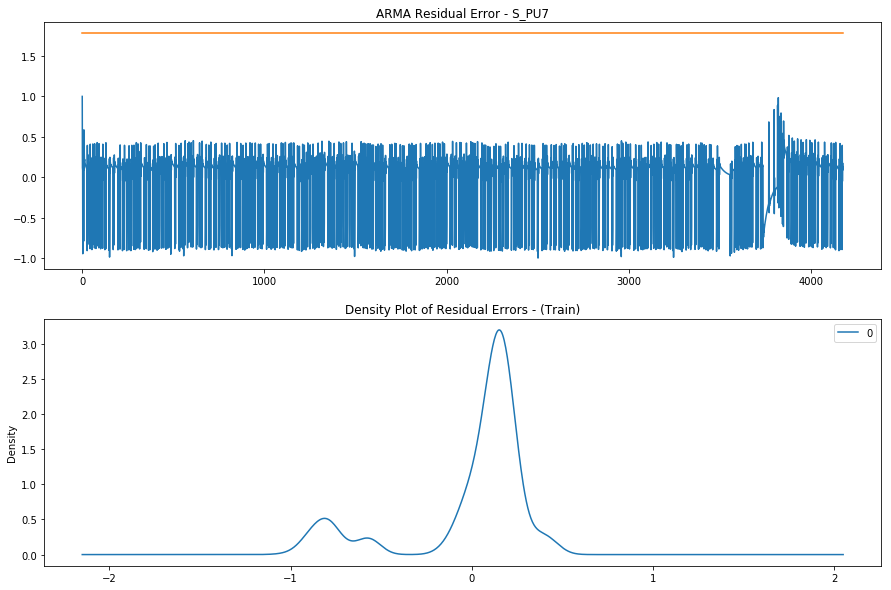

  -- TP :  0  || FP :  0


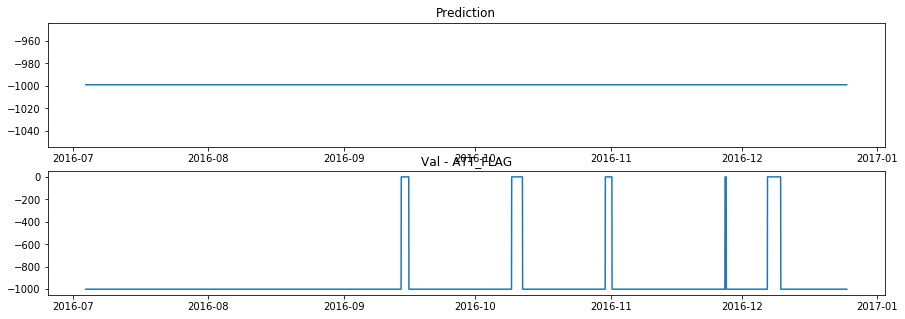


 ------------------ col :  S_PU8  -------------------- 
 - ARIMA Results :  4 2  || AIC :  5428.650908514246  (Time :  121.8 s)
  -- Threshold Val:  1.643


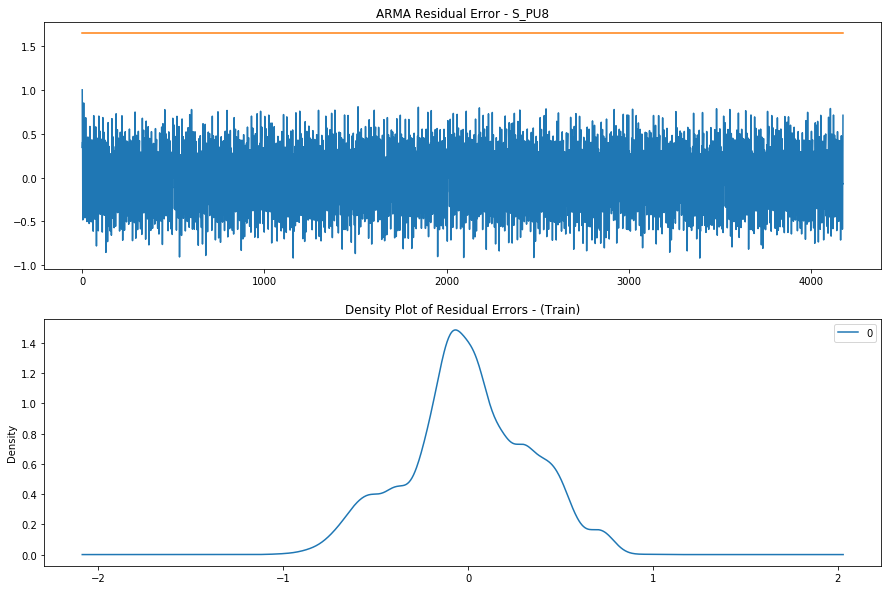

  -- TP :  0  || FP :  0


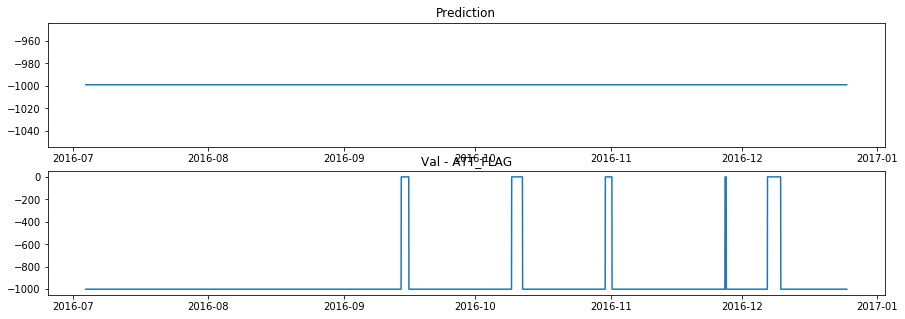


 ------------------ col :  F_PU10  -------------------- 
 - ARIMA Results :  2 4  || AIC :  66735.97855082167  (Time :  53.55 s)
  -- Threshold Val:  55.799


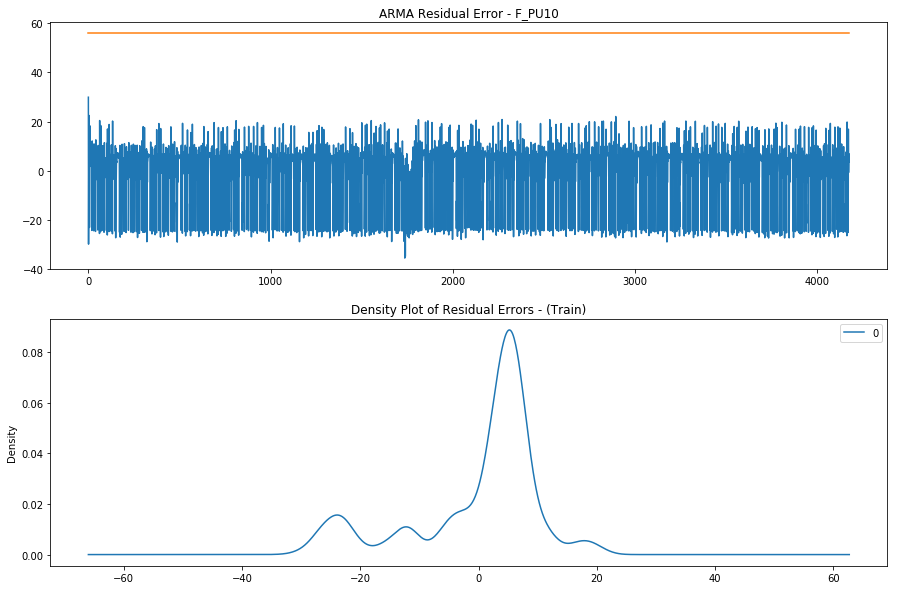

  -- TP :  0  || FP :  0


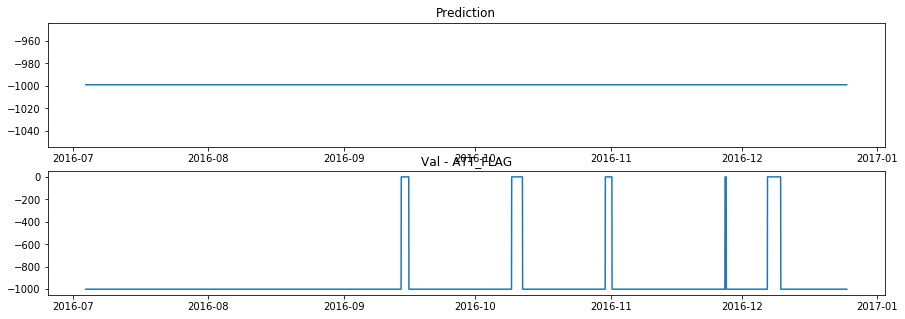


 ------------------ col :  S_PU10  -------------------- 
 - ARIMA Results :  2 4  || AIC :  6556.696204368673  (Time :  45.23 s)
  -- Threshold Val:  1.796


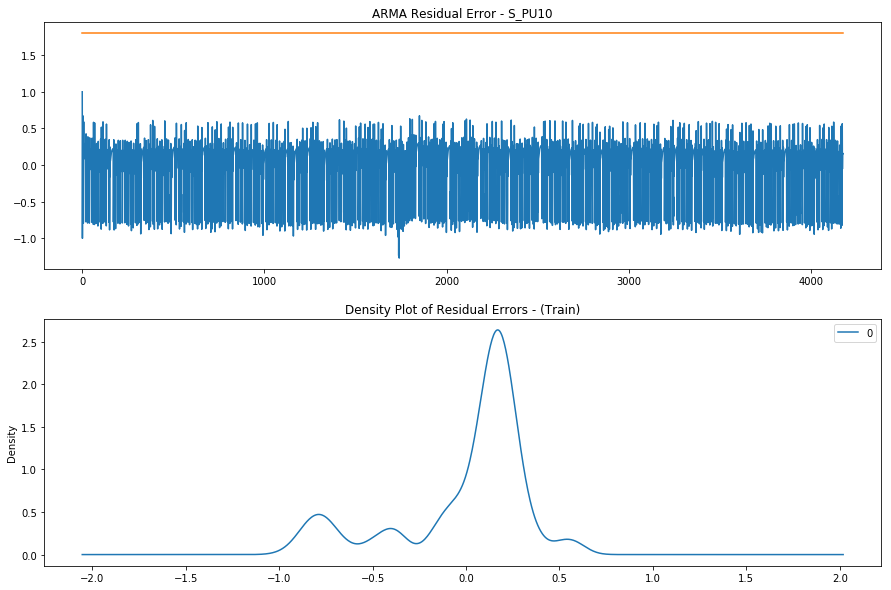

  -- TP :  0  || FP :  0


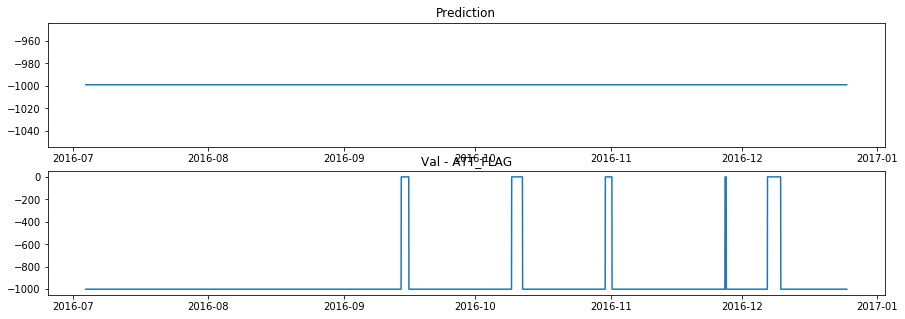


 ------------------ col :  F_PU11  -------------------- 
 - ARIMA Results :  1 1  || AIC :  7081.514647902477  (Time :  38.44 s)
  -- Threshold Val:  7.845


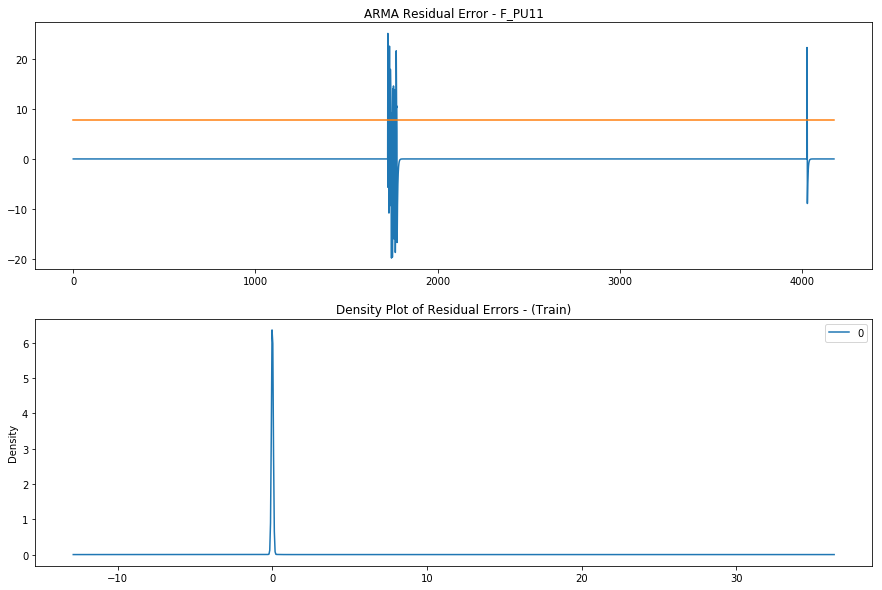

  -- TP :  0  || FP :  0


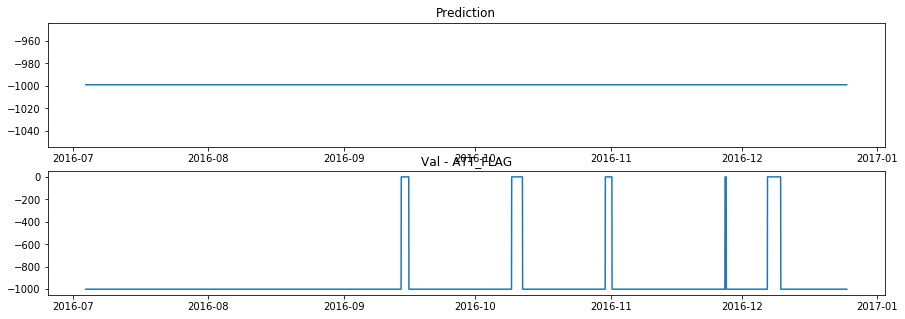


 ------------------ col :  S_PU11  -------------------- 
 - ARIMA Results :  2 3  || AIC :  -48600.172377933355  (Time :  223.68 s)
  -- Threshold Val:  0.305


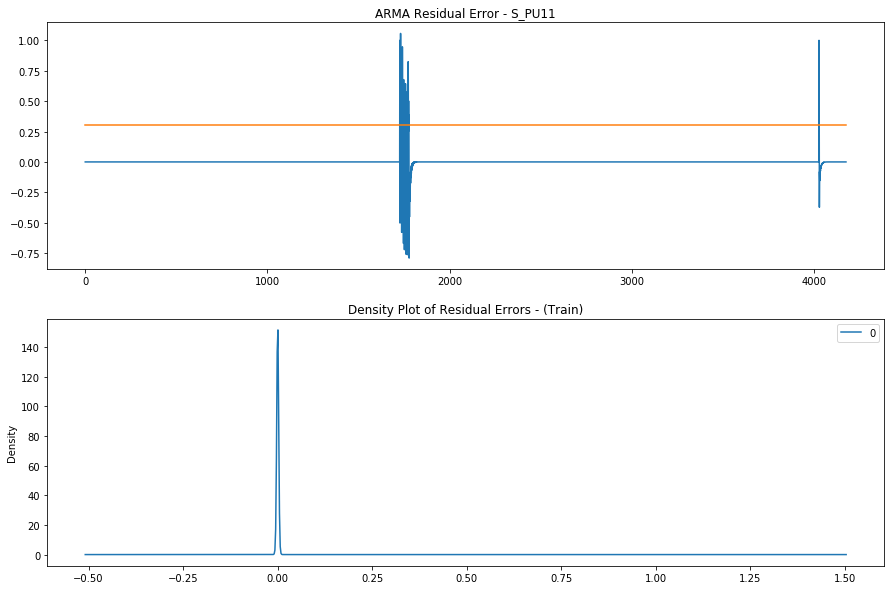

  -- TP :  15  || FP :  6


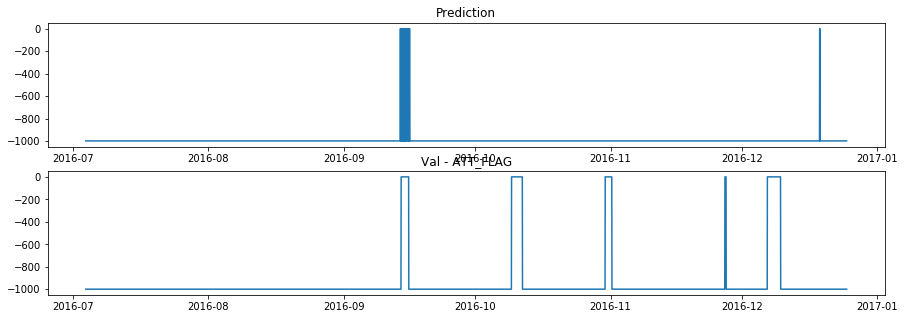


 ------------------ col :  S_V2  -------------------- 
 - ARIMA Results :  4 3  || AIC :  -237.55215713465077  (Time :  179.17 s)
  -- Threshold Val:  1.199


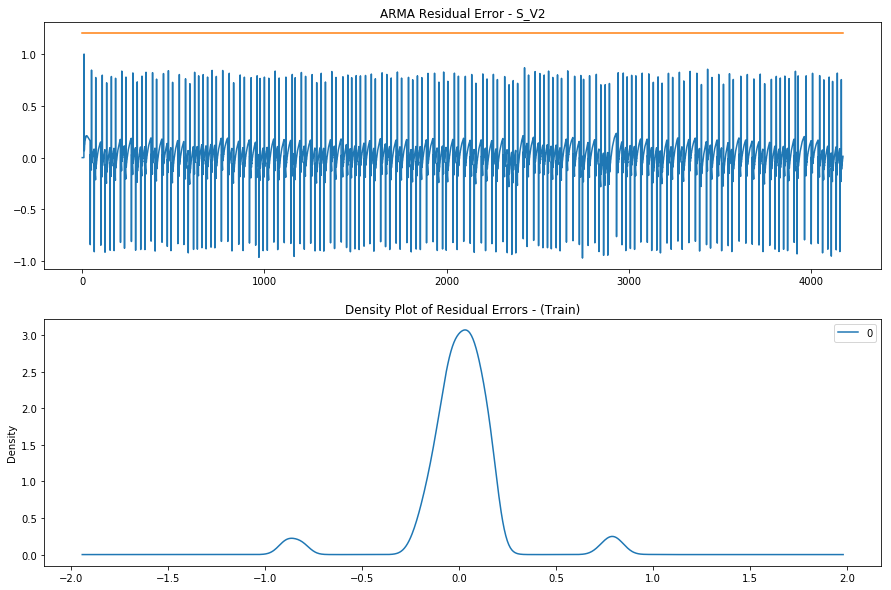

  -- TP :  0  || FP :  0


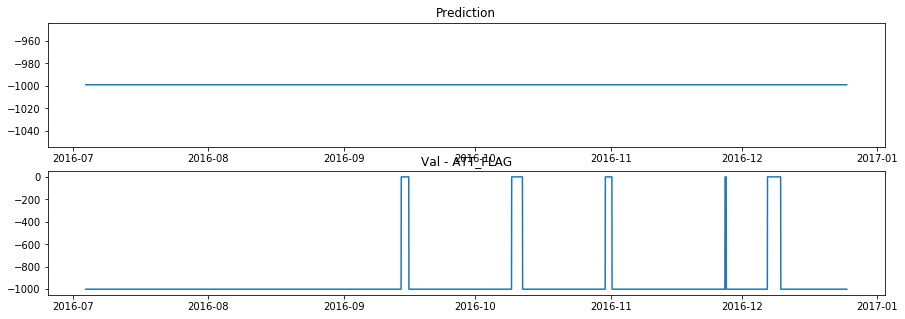


 ------------------ col :  P_J269  -------------------- 
 - ARIMA Results :  3 4  || AIC :  41137.92511909604  (Time :  144.4 s)
  -- Threshold Val:  13.188


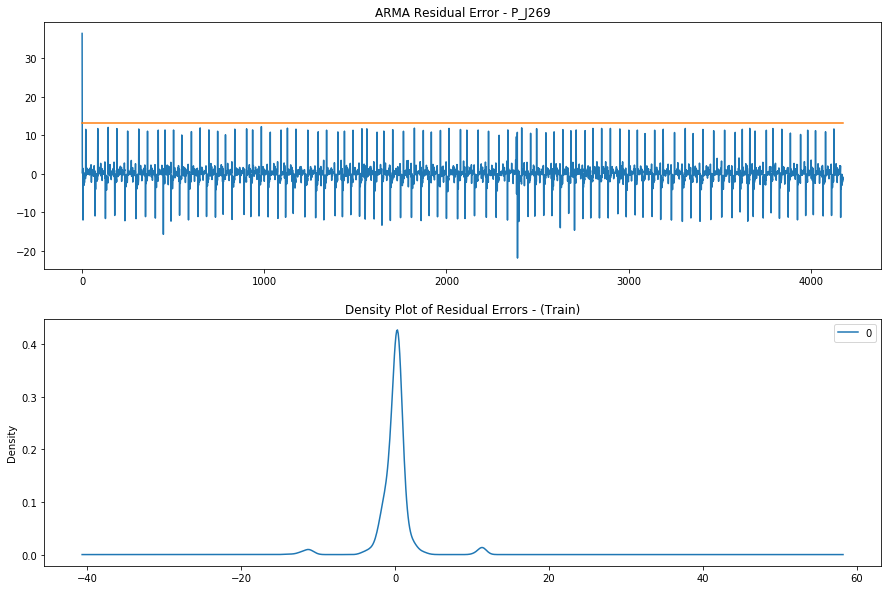

  -- TP :  0  || FP :  0


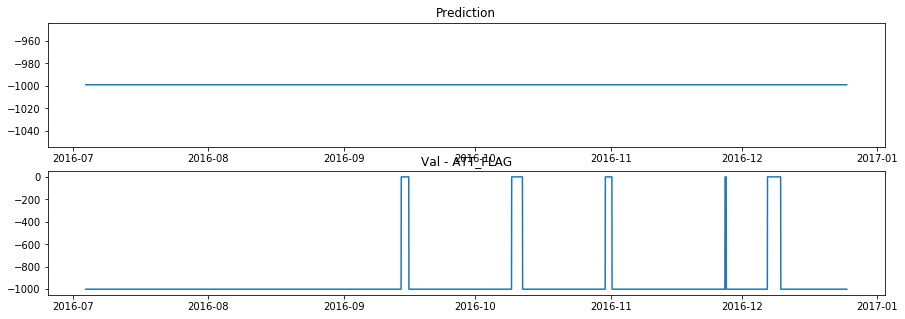


 ------------------ col :  P_J300  -------------------- 
 - ARIMA Results :  4 2  || AIC :  33027.42600822558  (Time :  161.92 s)
  -- Threshold Val:  8.376


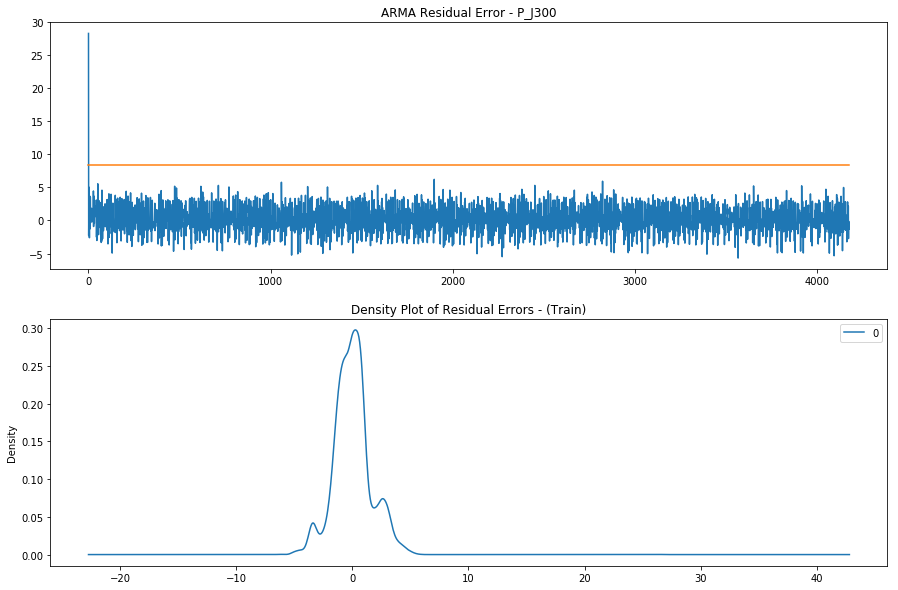

  -- TP :  0  || FP :  0


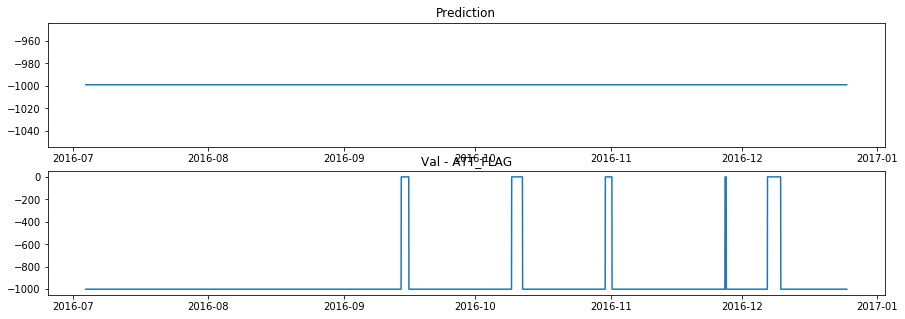


 ------------------ col :  P_J256  -------------------- 
 - ARIMA Results :  4 2  || AIC :  53816.584027837554  (Time :  33.36 s)
  -- Threshold Val:  26.751


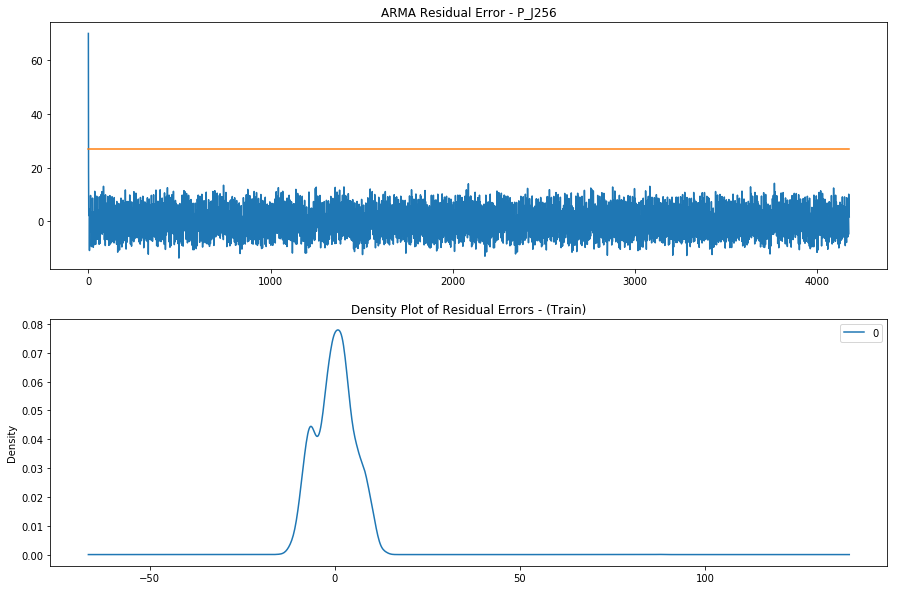

  -- TP :  0  || FP :  0


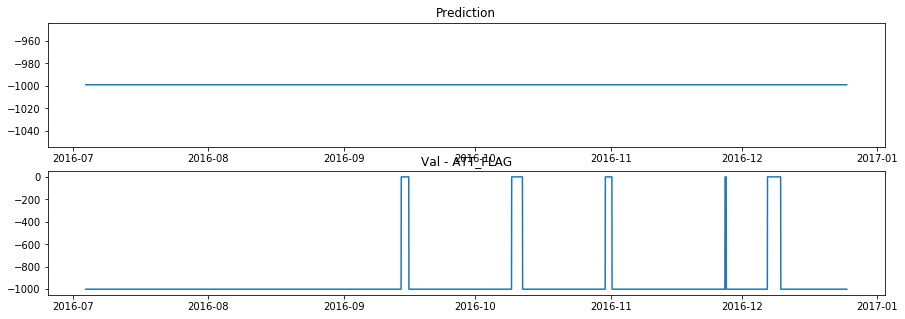


 ------------------ col :  P_J415  -------------------- 
 - ARIMA Results :  2 4  || AIC :  59447.76868948179  (Time :  114.86 s)
  -- Threshold Val:  36.884


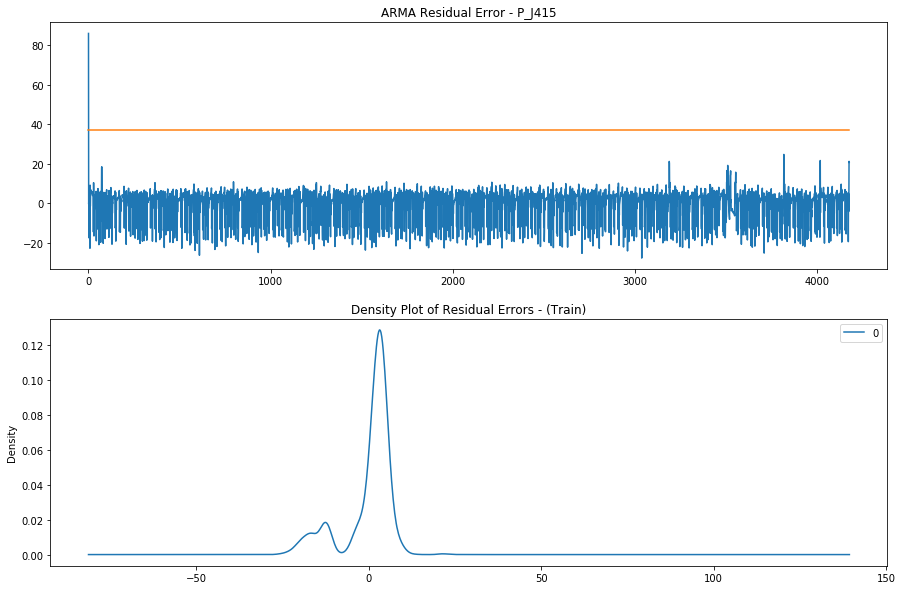

  -- TP :  0  || FP :  0


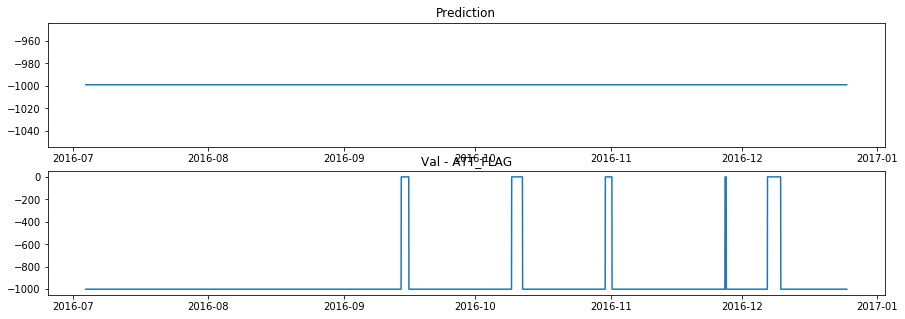


 ------------------ col :  P_J302  -------------------- 
 - ARIMA Results :  4 4  || AIC :  45324.921471935784  (Time :  83.64 s)
  -- Threshold Val:  17.594


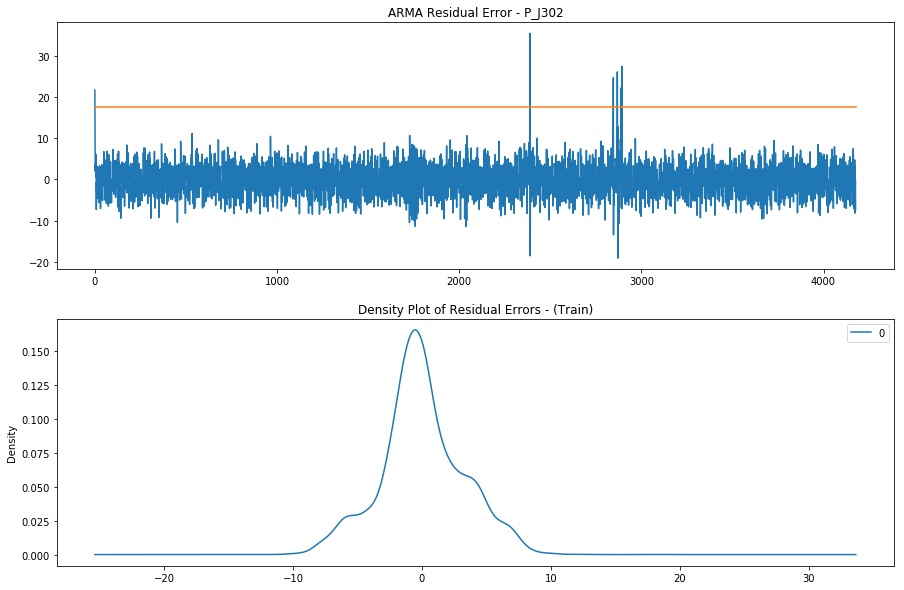

  -- TP :  0  || FP :  0


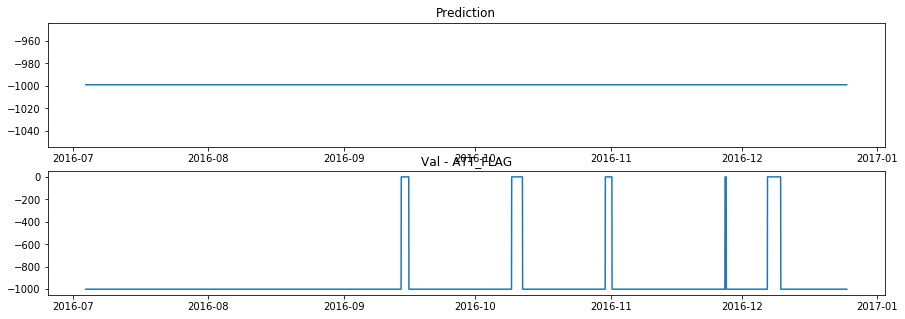


 ------------------ col :  P_J307  -------------------- 
 - ARIMA Results :  4 4  || AIC :  45530.55678094627  (Time :  108.46 s)
  -- Threshold Val:  17.614


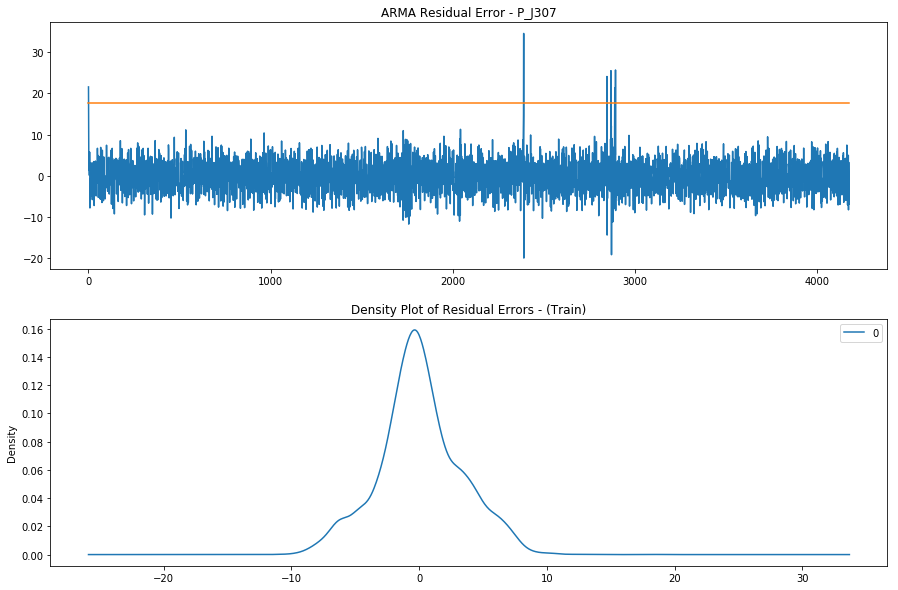

  -- TP :  0  || FP :  0


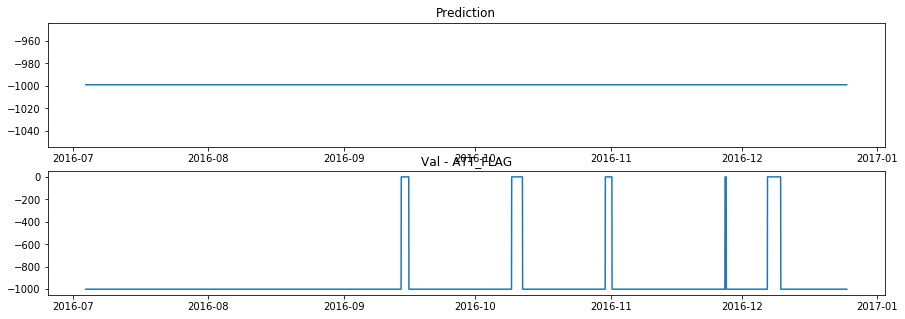


 ------------------ col :  P_J317  -------------------- 
 - ARIMA Results :  1 1  || AIC :  54174.529869492006  (Time :  19.15 s)
  -- Threshold Val:  28.732


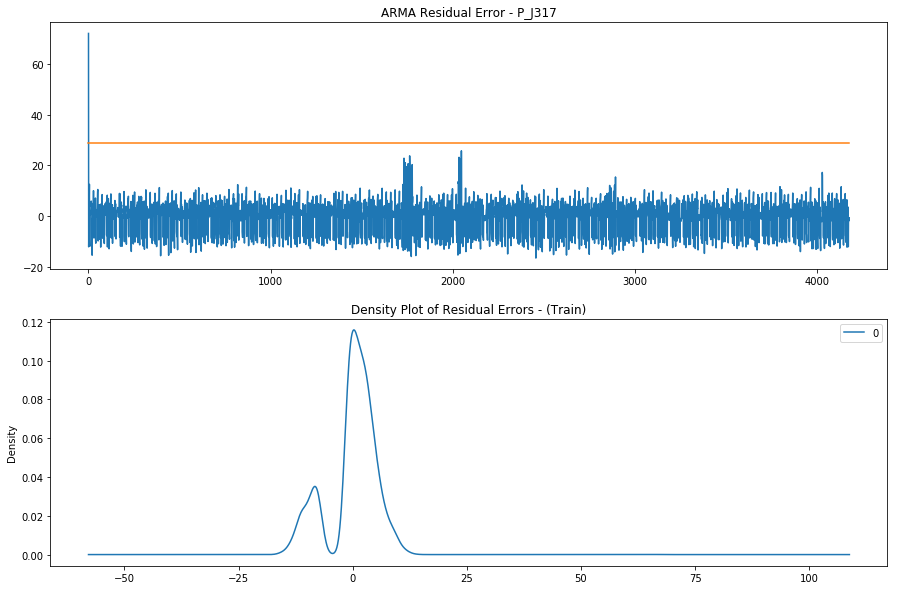

  -- TP :  0  || FP :  0


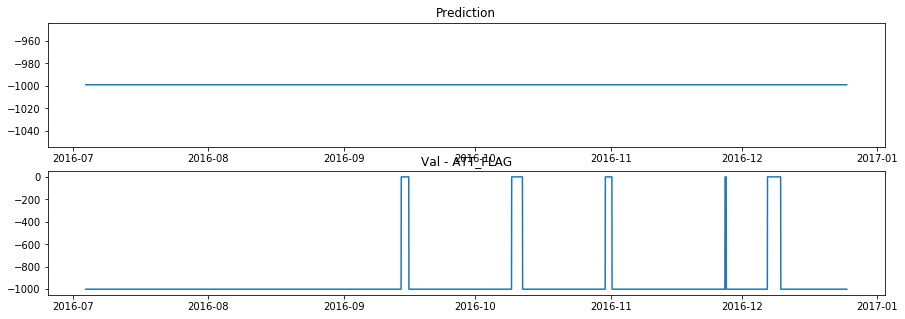


 ------------------ col :  P_J14  -------------------- 
 - ARIMA Results :  4 4  || AIC :  41853.24256933754  (Time :  253.67 s)
  -- Threshold Val:  14.804


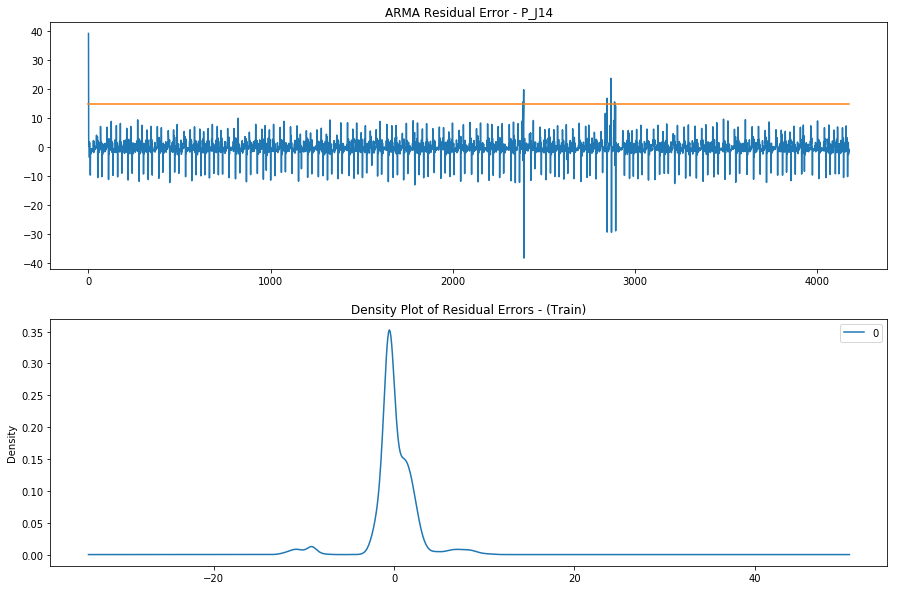

  -- TP :  0  || FP :  0


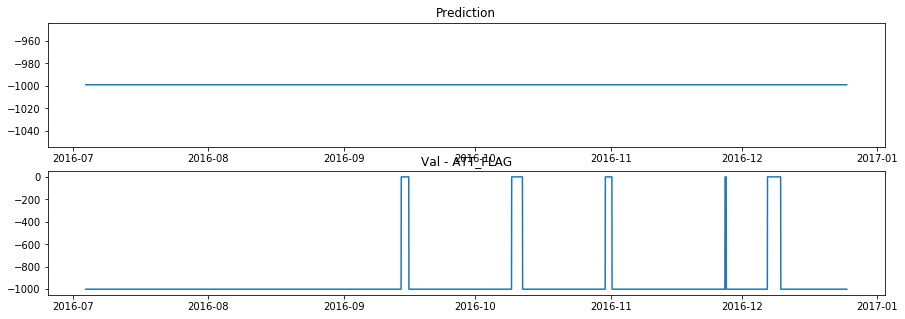


 ------------------ col :  P_J422  -------------------- 
 - ARIMA Results :  4 2  || AIC :  32060.14812026977  (Time :  146.32 s)
  -- Threshold Val:  7.974


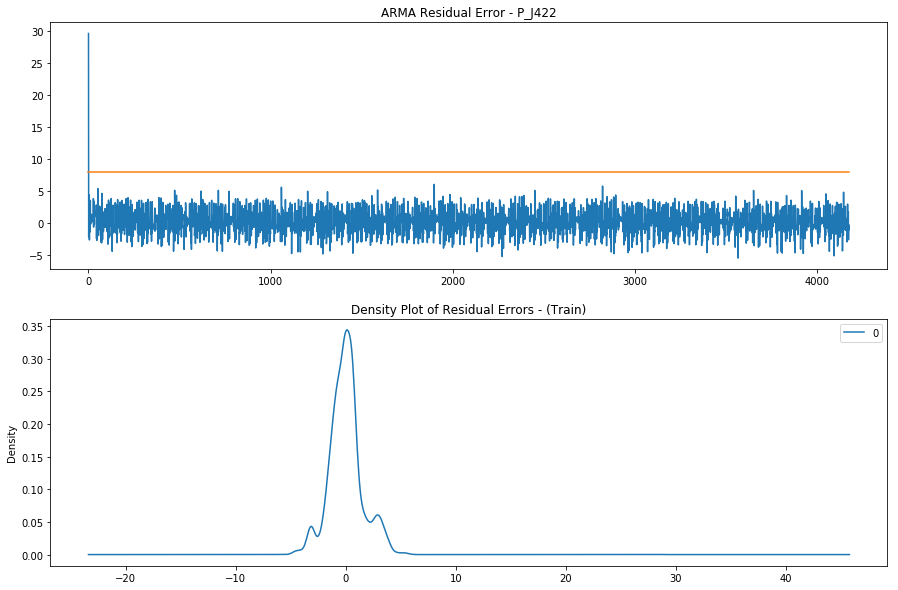

  -- TP :  0  || FP :  0


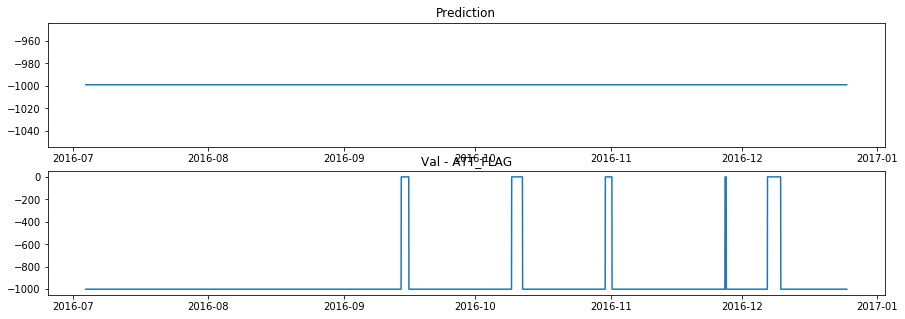

,col,best_p,best_q,best_aic,threshold_train,threshold_val,val_rmse,anomalies,TN,FN,FP,TP,accuracy,precision,recall,f_score
0,L_T1,3,4,-13232.106912,0.568049,0.762953,-1,219,3955,216,3,3,94.757003,50.000000,1.369863,2.666667
1,L_T2,4,4,-228.310512,1.193376,1.244773,-1,219,3958,219,0,0,94.757003,0.000000,0.000000,0.000000
2,L_T3,3,4,-7158.990509,0.824538,0.849488,-1,219,3956,219,2,0,94.709121,0.000000,0.000000,0.000000
3,L_T4,4,2,8236.754399,1.939603,1.971779,-1,219,3958,219,0,0,94.757003,0.000000,0.000000,0.000000
4,L_T5,4,4,-517.008473,1.181904,1.182771,-1,219,3958,219,0,0,94.757003,0.000000,0.000000,0.000000
5,L_T6,3,2,-12467.224293,0.657551,0.731602,-1,219,3957,219,1,0,94.733062,0.000000,0.000000,0.000000
6,L_T7,3,4,14075.772818,2.699144,2.734012,-1,219,3958,219,0,0,94.757003,0.000000,0.000000,0.000000
7,F_PU1,4,2,51591.605021,23.543326,24.597928,-1,219,3958,219,0,0,94.757003,0.000000,0.000000,0.000000
8,F_PU2,1,3,76308.242164,93.757407,94.511366,-1,219,3958,219,0,0,94.757003,0.000000,0.000000,0.000000
9,S_PU2,1,1,-3460.890908,0.988651,0.996267,-1,219,3878,214,80,5,92.961456,5.882353,2.283105,3.289474


,L_T1,L_T2,L_T3,L_T4,L_T5,L_T6,L_T7,F_PU1,F_PU2,S_PU2,F_PU4,S_PU4,F_PU6,S_PU6,F_PU7,S_PU7,S_PU8,F_PU10,S_PU10,F_PU11,S_PU11,S_V2,P_J269,P_J300,P_J256,P_J415,P_J302,P_J307,P_J317,P_J14,P_J422
0,1,-999,1,-999,-999,1,-999,-999,-999,1,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999
1,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999
2,-999,-999,1,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999
3,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999
4,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999
5,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999
6,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999
7,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999
8,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999
9,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999


'\n - plot the ATT_FLAG=1 on the residual errors\n'

In [5]:
def doARIMA(df_train, df_val, col, res_std_factor=5, plot=1):
    t1 =time.time()
    print ('')
    print (' ------------------ col : ',col,' -------------------- ')
    
    p = range(1, 5)
    q = range(1, 5)
    best_aic         = np.inf
    model_train_best = None
    best_p = -1; 
    best_q = -1
    
    for p_ in p:
        for q_ in q:
            try:
                # model = smt.ARIMA(data, order=(p_,0,q_)).fit(method='mle', trend='nc',disp=-1,full_output=False)
                model_train = ARIMA(df_train[col], order=(p_,0,q_)).fit(method='mle', trend='nc',disp=0,full_output=True)
                if model_train.aic < best_aic:
                    best_aic         = model_train.aic
                    best_p           = p_
                    best_q           = q_
                    model_train_best = model_train
            except:
                pass
                # traceback.print_exc()
    print(' - ARIMA Results : ', best_p, best_q, ' || AIC : ', best_aic, ' (Time : ',round(time.time()-t1,2),'s)')
    
    threshold_train = -1
    threshold_val   = -1
    rmse            = -1
    anomalies       = 0;
    TN = 0; FN = 0; TP=0; FP=0;
    
    
    try:
        if (model_train_best != None):

            threshold_train = res_std_factor * np.std(model_train_best.resid)
            if (0):
                # Step2 - We plot the residual errors to see if there may still be some trend information not captured by the model.
                print ('  -- Threshold Train : ', round(threshold_train,3))
                f,axarr = plt.subplots(3,1, figsize=(15,10))
                axarr[0].plot(df_train[col])
                axarr[0].set_title('Train Data - ' + col)
                axarr[1].plot(list(model_train_best.resid))
                axarr[1].plot([0,len(model_train_best.resid)], [threshold_train, threshold_train]);
                axarr[1].set_title('ARMA Residual Error - ' + str(col))
                residuals = pd.DataFrame(model_train_best.resid)
                residuals.plot(kind='kde', ax=axarr[2], title='Density Plot of Residual Errors')
                plt.show()

            # Step3 - applying best_p, best_q to val data
            model_val = ARIMA(df_val[col], order=(best_p,0,best_q)).fit(method='mle', trend='nc',disp=0,full_output=True)
            threshold_val = res_std_factor * np.std(model_val.resid)
            if (1):
                print ('  -- Threshold Val: ', round(threshold_val,3))
                f,axarr = plt.subplots(2,1, figsize=(15,10))
                #axarr[0].plot(df_val[col])
                #axarr[0].set_title('Val Data - ' + col)
                axarr[0].plot(list(model_val.resid))
                axarr[0].plot([0,len(model_val.resid)], [threshold_val, threshold_val]);
                axarr[0].set_title('ARMA Residual Error - ' + str(col))
                #residuals = pd.DataFrame(model_val.resid)
                residuals = pd.DataFrame(model_train_best.resid)
                residuals.plot(kind='kde', ax=axarr[1], title='Density Plot of Residual Errors - (Train)')
                plt.show()
            
            # Step4 - Prediction
            if (0):
                Y_predict = model_val.predict()
                mse = mean_squared_error(df_val[col], Y_predict)
                rmse = np.sqrt(mse)    
                if plot:
                    f,axarr = plt.subplots(1, figsize=(15,5))
                    plt.plot(Y_predict)
                    plt.plot(df_val[col])
                    print (' - Val MSE : ', round(mse, 2), ' || Val RMSE : ', round(rmse,2))
                    plt.title('Prediction - Validation - Col:' + col + ' (RMSE:' + str(round(np.sqrt(mse),2)) + ')')
                    plt.show()            
            
            # Step5 - Getting y_predict
            if (1):
                Y_true    = df_val['ATT_FLAG']
                anomalies = Counter(Y_true)[1]
                Y_predict = model_val.resid
                Y_predict[Y_predict >= threshold_val] = 1
                Y_predict[Y_predict < threshold_val] = -999;
                Y_predict = Y_predict.astype(int)
                conf_matrix = confusion_matrix(Y_true, Y_predict)
                TN = conf_matrix[0][0]
                FN = conf_matrix[1][0]
                FP = conf_matrix[0][1]
                TP = conf_matrix[1][1]
                accuracy = 100.0 * (TP + TN)/(TP + TN + FP + FN)
                if (TP + FP) != 0:
                  precision = 100.0 * (TP / (TP + FP))
                else:
                  precision = 0
                recall  = 100.0 * (TP / (TP + FN))
                f_score = 100.0 * 2 * (TP /(2*TP + FP + FN))
                print ('  -- TP : ', TP, ' || FP : ', FP)
                
                f, axarr = plt.subplots(2,1, figsize=(15,5))
                axarr[0].plot(Y_predict)
                axarr[0].set_title('Prediction')
                axarr[1].plot(df_val['ATT_FLAG'])
                axarr[1].set_title('Val - ATT_FLAG')
                plt.show()
                
                
                
                
                # import pdb; pdb.set_trace()
            else:
                det_anom_lit = model_val.resid[model_val.resid > threshold_val]
                ind = []
                TP = 0
                FP = 0
                for index, a in det_anom_lit.items():
                    ind.append(index)
                    if df_val['ATT_FLAG'][index] == 1 : TP += 1
                    else                              : FP += 1
                print ('  -- TP : ', TP, ' || FP : ', FP)
                
    except:
        print (' - Error : ', col)
        # traceback.print_exc()
        pass
    
    res = [col, best_p, best_q, best_aic, threshold_train, threshold_val, rmse, anomalies, TN,FN, FP, TP, accuracy,precision, recall,f_score ]
    return res, Y_predict

if __name__ == "__main__":
    
    f,axarr = plt.subplots(1, figsize=(15,5))
    axarr.plot(df_val['ATT_FLAG'])
    axarr.set_title('ATT_FLAG - {0}'.format(str(Counter(df_val['ATT_FLAG']))))    
    
    data = []
    arma_pred = []
    cols = df_train.columns[:-1]
    #cols = ['L_T1']
    cols = ['L_T1', 'L_T2', 'L_T3', 'L_T4', 'L_T5', 'L_T6', 'L_T7', 'F_PU1', 'F_PU2', 'S_PU2', 'F_PU4', 'S_PU4', 'F_PU6', 'S_PU6', 'F_PU7', 'S_PU7', 'S_PU8', 'F_PU10', 'S_PU10', 'F_PU11', 'S_PU11', 'S_V2',
       'P_J269', 'P_J300', 'P_J256', 'P_J415', 'P_J302', 'P_J307', 'P_J317', 'P_J14', 'P_J422']

    for i,col in enumerate(cols):
          tmp, tmp1 = doARIMA(df_train, df_val, col, plot=0)
          data.append(tmp)
          arma_pred.append(tmp1)
    
    arma_pred = np.array(arma_pred).T
    
    df = pd.DataFrame(data, columns=['col', 'best_p', 'best_q', 'best_aic', 'threshold_train', 'threshold_val', 'val_rmse', 'anomalies', 'TN', 'FN', 'FP', 'TP', 'accuracy', 'precision', 'recall', 'f_score'])
    display(df) 
    df1 = pd.DataFrame(arma_pred, columns=cols)
    display(df1)
    df.to_csv('results/02_ARMA_results.csv', index=False)
    df1.to_csv('results/02_ARMA_pred.csv', index=False)
"""
 - plot the ATT_FLAG=1 on the residual errors
"""

In [0]:
arma_pred.shape

(4177, 1)

In [0]:
f,axarr = plt.subplots(1, figsize=(15,5))
axarr.plot(df_val['ATT_FLAG'])
axarr.set_title('ATT_FLAG - {0}'.format(str(Counter(df_val['ATT_FLAG']))))
tmp = df_val[df_val['ATT_FLAG'] == 1]

In [0]:
tmp.index

# Tmp


Sensors to check for : Select 5 based on F1 score. 

In [0]:
# used for testing purposes. not required to run.
col = 'F_PU1'
model_train_best = ARIMA(df_train[col], order=(3,0,3)).fit(method='mle', trend='nc',disp=0,full_output=True)

threshold = 5 * np.std(model_train_best.resid)
print ('  -- Threshold : ', round(threshold,3))
f,axarr = plt.subplots(3,1, figsize=(15,10))
axarr[0].plot(df_train[col])
axarr[0].set_title('Train Data - ' + col)
axarr[1].plot(list(model_train_best.resid))
axarr[1].plot([0,len(model_train_best.resid)], [threshold, threshold]);
axarr[1].set_title('ARMA Residual Error - ' + str(col))
residuals = pd.DataFrame(model_train_best.resid)
residuals.plot(kind='kde', ax=axarr[2], title='Density Plot of Residual Errors')
plt.show()

model_val = ARIMA(df_val[col], order=(3,0,3)).fit(method='mle', trend='nc',disp=0,full_output=True)

threshold = 5 * np.std(model_val.resid)
print ('  -- Threshold : ', round(threshold,3))
f,axarr = plt.subplots(3,1, figsize=(15,10))
axarr[0].plot(df_val[col])
axarr[0].set_title('Val Data - ' + col)
axarr[1].plot(list(model_val.resid))
axarr[1].plot([0,len(model_val.resid)], [threshold, threshold]);
axarr[1].set_title('ARMA Residual Error - ' + str(col))
residuals = pd.DataFrame(model_val.resid)
residuals.plot(kind='kde', ax=axarr[2], title='Density Plot of Residual Errors')
plt.show()

Y_predict = model_val.predict()
f,axarr = plt.subplots(1, figsize=(15,5))
plt.plot(Y_predict)
plt.plot(df_val[col])
mse = mean_squared_error(df_val[col], Y_predict)
print (' - Val MSE : ', round(mse, 2), ' || Val RMSE : ', round(np.sqrt(mse),2))
plt.title('Prediction - Validation - Col:' + col + ' (RMSE:' + str(round(np.sqrt(mse),2)) + ')')

det_anom_lit = model_val.resid[model_val.resid > threshold]
ind = []
TP = 0
FP = 0
for index, a in det_anom_lit.items():
    print (a)
    ind.append(index)
    if df_val['ATT_FLAG'][index] == 1 : TP += 1
    else                          : FP += 1

print ('  -- TP : ', TP, ' || FP : ', FP)